<h1>1 Импортирование необходимых модулей, функционала</h1>

In [1]:
import warnings
from tqdm import tqdm_notebook, tqdm
import pickle

import numpy as np
import pandas as pd
from itertools import combinations

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from lightgbm import LGBMClassifier

import shap
import eli5
from eli5.sklearn import PermutationImportance

tqdm.pandas()
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Версии всех внешних модулей представлены в файле "requirements.txt".

<h1>2 Глобальные параметры</h1>

In [2]:
# Список метрик, на основе которых будем оценивать успешность обучения модели
metrics = [accuracy_score, roc_auc_score]

# Установка значения для генератора псевдослучайных чисел; необходимо для воспроизводимости результатов
SEED = 42

# Ключ для объединения данных разных годов
key = 'customer'

Словарь признаков для конвертации в удобный для работы с ними вид.

In [3]:
overdue_ar_params = {
    'Макс. ПДЗ за год, дней':                        'max_ar',
    'Сред. ПДЗ за год, дней':                        'avg_ar',
    'Кол-во просрочек свыше 5-ти дней за год, шт.':  'ar_count5',
    'Общая сумма ПДЗ свыше 5-ти дней за год, руб.':  'ar_sum',
    'Кол-во раз ПДЗ за год, шт.':                    'ar_count'
}

balance_sections = {
    'Внеоборотные активы':                 'non_current_assets',
    'Нематериальные активы':               'intangible_assets',
    'Основные средства':                   'property_plant_equipment',
    'Оборотные активы':                    'current_assets',
    'Дебиторская задолженность':           'accounts_receivable',
    'Капитал и резервы':                   'capital_and_reserves',
    'Уставный капитал':                    'share_capital',
    'Долгосрочные обязательства':          'non_current_liabilities',
    'Заёмные средства (долгосрочные)':     'nc_borrowings',
    'Краткосрочные обязательства':         'current_liabilities',
    'Заёмные средства (краткосрочные)':    'c_borrowings',
    'Кредиторская задолженность':          'accounts_payable',
    'Выручка':                             'revenue',
    'Себестоимость продаж':                'cost_amount',
    'Прибыль (убыток) от продажи':         'sales_profit',
    'Прибыль (убыток) до налогообложения': 'profit_before_tax'
}

other = {
    'Наименование ДП':                       'customer',
    'Оценка потенциала контрагента 1, руб.': 'score1',
    'Оценка потенциала контрагента 2, руб.': 'score2', 
    'Статус':                                'status',
    'ПДЗ 1-30':                              'oar1_30', 
    'ПДЗ 31-90':                             'oar31_90', 
    'ПДЗ 91-365':                            'oar91_365', 
    'ПДЗ более 365':                         'oar_over365'
}

<h1>3 Разведочный анализ данных</h1>

Создание вспомогательных функций для разведочного анализа данных.

In [4]:
def factor_rename(data, factor:str):
    
    """
    Функция предназначена для конвертации названий факторных признаков в удобный
    для работы с ними вид.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, в которых содержатся требуемые признаки;
    factor: str - название фактора.
    Функция ничего не возвращает; она изменяет названия признаков, которые
    содержатся в переданных ей данных (data).
    """
    
    if isinstance(factor, str):   
            if factor != 'Итого':
                data.rename(columns={factor: 'f{idx}'.format(idx=factor[-2:].strip())}, inplace=True)
            else:
                data.rename(columns={factor: 'Sum'}, inplace=True)
    else:
        raise TypeError('Аргумент "factor" должен принимать строковое значение')

In [5]:
def balance_sections_rename(data, column:str):
    
    """
    Функция предназначена для конвертации названий балансовых признаков в удобный
    для работы с ними вид.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, в которых содержатся требуемые признаки;
    column: str - название балансового признака.
    Функция ничего не возвращает; она изменяет названия балансовых признаков,
    которые содержатся в переданных ей данных (data).
    """
    
    if isinstance(column, str):
        data.rename(columns={column: '{one}{two}'.format(one=balance_sections[column.split(',')[1].strip()],
                                                         two=column.split(',')[0][2:].strip())}, inplace=True)
    else:
        raise TypeError('Аргумент "column" должен принимать строковое значение')

In [6]:
def overdue_ar_params_rename(data, ar_param:str):
    
    """
    Функция предназначена для конвертации названий целевых признаков в удобный
    для работы с ними вид.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, в которых содержатся требуемые признаки;
    ar_param: str - название целевого признака.
    Функция ничего не возвращает; она изменяет названия целевых признаков,
    которые содержатся в переданных ей данных (data).
    """
    
    if isinstance(ar_param, str):
        splitted_col, param = ar_param.split(' '), ''
        for el in splitted_col:
            if not el.isnumeric():
                param += ' ' + el
            else:
                year = el
        data.rename(columns={ar_param: '{one}{two}'.format(one=overdue_ar_params[param.strip()], two=year[2:])},
                    inplace=True)
    else:
        raise TypeError('Аргумент "ar_param" должен принимать строковое значение')

In [7]:
def features_rename(data, columns):
    
    """
    Функция предназначена для переименования признаков в удобный для работы с ними вид.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, в которых содержатся требуемые признаки;
    columns: list - список признаков, которые необходимо переименовать.
    Функция ничего не возвращает; она изменяет названия признаков, которые содержатся
    в переданных ей данных (data).
    """
    
    if isinstance(columns, list):
        for col in columns:
            if col in list(other.keys()):
                data.rename(columns={col: other[col]}, inplace=True)
            elif ('Факт' in col) | ('Итого' in col):
                factor_rename(data, col)
            elif col[0].isnumeric():
                balance_sections_rename(data, col)
            else:
                overdue_ar_params_rename(data, col)
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

In [8]:
def detect_null_data(data, columns):
    
    """
    Функция предназначена для обнаружения пустых наблюдений (строк) в переданных ей данных.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых необходимо найти пустые наблюдения;
    columns: list - список названий признаков (столбцов) данных, которые будут использованы
    для поиска пустых наблюдений.
    Функция возвращает список, содержащий индексы пустых наблюдений.
    """
    
    if isinstance(columns, list):
        null_data = []
        for i in tqdm_notebook(data.index.to_list()):
            sum_ = 0
            current_row = data.loc[i, columns].values
            for j in range(len(current_row)):
                if current_row[j] == 0:
                    sum_ += 1
            if sum_ == len(current_row):
                null_data.append(i)
        print(len(null_data))
        return null_data
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

In [9]:
def factor_filling(data, columns, value=-1):
    
    """
    Функция предназначена для заполнения содержательными значений факторных признаков.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых необходимо заполнить факторные признаки;
    columns: list - список факторных признаков;
    value: int - значение, которым будет замещено некорректное по факторным признакам, 
    значение по умолчанию равно -1.
    Функция ничего не возвращает, она преобразовывает исходные данные (data).
    """
    
    if isinstance(columns, list):
        for col in columns:
            if data[col].isna().sum() != 0:
                data[col].fillna(value, inplace=True)
            else:
                data[col] = data[col].apply(lambda x: -1 if x in ['X', 'Х', 'Н/Д'] else int(x))
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

In [10]:
def factor_cleaning(data, columns):
    
    """
    Функция предназначена для фильтрования факторных признаков.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых необходимо отфильтровать факторные признаки;
    columns: list - список факторных признаков.
    Функция ничего не возвращает, она удаляет факторные признаки, в которых объём
    пустых значений, т.е. значений равных -1, равен объёму исходных данных (data).
    """
    
    to_drop = []
    for col in columns:
        if -1 in data[col].value_counts():
            if data[col].value_counts()[-1] == len(data):
                to_drop.append(col)
    data.drop(to_drop, axis=1, inplace=True)
    print(f' Удалено {len(to_drop)}: \n{to_drop}')

In [11]:
def del_high_corr(data, cut_off=0.7):
    
    """
    Функция предназначена для удаления признаков, у которых корреляция выше некоторого порога.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых будет рассчитана матрица корреляций;
    cut_off: float - порог отсечения коррелирующих признаков, значение по умолчанию равно 0.7,
    что в соответствии с таблицей Чеддока соответствует высокой силе корреляционной связи.
    Функция ничего не возвращает, она удаляет признаки, корреляция которых превышает установленный
    порог.
    """
    
    i, to_drop = 0, []
    while True:
        corr_ = data.corr() >= cut_off
        tmp = list(zip(corr_.sum().index, corr_.sum()))
        if tmp[i][1] > 1:
            data.drop(tmp[i][0], axis=1, inplace=True)
            print(f'Признак {tmp[i][0]} был удалён')
        else:
            i +=1
        if data.shape[1] == corr_.sum().values.sum():
            break

In [12]:
def find_unique_columns(columns1, columns2):
    
    """
    Функция предназначена для поиска уникальных значений двух списков признаков.
    Функция принимает следующие параметры:
    columns1: list - первый список признаков;
    columns2: list - второй список признаков.
    Функция возвращает список уникальных признаков.
    """
    
    
    if isinstance(columns1, list) | isinstance(columns2, list):
        cols1, cols2 = set(columns1), set(columns2)
        return list(cols1.difference(cols2))
    else:
        raise TypeError('Аргумент "columns" должен принимать строковое значение')

In [13]:
def remove_empty_factors(data, columns, cut_off=5):
    
    """
    Функция предназначена для удаления факторных признаков, в которых пустые значения превышают
    установленный допустимый порог их содержания.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых будет осуществлён поиск пустых факторных признаков;
    columns: list - список признаков;
    cut_off: float - порог отсечения пустых факторных признаков, значение по умолчанию равно 5.
    Функция ничего не возвращает; она удаляет факторные признаки, в которых пустые значения
    превышают или равны порого отсечения.
    """
    
    if isinstance(columns, list):
        for col in columns:
            if (len(data) - data[col].value_counts()[-1]) <= cut_off:
                print(f'{col} was dropped')
                data.drop(col, axis=1, inplace=True)
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

In [14]:
def check_empty_cols(data, columns, cut_off=0.5):
    
    """
    Функция предназначена для поиск пустых признаков.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные, для которых будет осуществлён поиск пустых признаков;
    columns: list - список признаков;
    cut_off: float - порог отсечения пустых признаков, значение по умолчанию равно 0.5.
    Функция возвращает спико признаков, в которых объём пустых значений превышает установленный порог.
    """
    
    drop_params = []
    if isinstance(columns, list):
        for col in columns:
            try:
                val = round(data[col].value_counts()[-1] / len(data), ndigits=5)
                if val > cut_off:
                    print(col, val)
                    drop_params.append(col)
            except KeyError:
                val = round(data[col].value_counts()[0] / len(data), ndigits=5)
                if val > cut_off:
                    print(col, val)
                    drop_params.append(col)
        print(len(drop_params))
        return drop_params
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

In [15]:
def isfact(name):
    
    """
    Функция предназначена для определения по названию - является ли поле "Фактом", или нет.
    Функция принимает следующие параметры:
    name: str - наименование признака;
    Функция возвращает булево значение True - в положительном случае, False - в отрицательном.
    """
    
    lenth = len(name)
    prefix = name[0]
    postfix = name[1:]
    
    if lenth <=3:
        if prefix == 'f':
            if postfix.isdigit():
                return True
    return False

In [16]:
def rename_years(columns, actual_year, diffs):
    
    """
    Функция предназначена для изменения прямого номера года в названии признака, на относительный.
    Функция принимает следующие параметры:
    columns: list/index - список признаков;
    actual_year: int - номер года, относительно которого дклается нумерация;
    diffs: dict - сопоставления цифрового отклонения года в признаке, его постфиксу, который нужно присвоить
    Функция возвращает список полей, в которых признаки с прямым указанием года переименованы
    """
    
    new_columns = []
    for name in columns:
        if not isfact(name):
            tail = name[-2:]
            if tail.isdigit():
                tail = int(tail)
                tail = tail - actual_year
                if tail == 0:
                    name = name[:-2]
                elif tail > 0 or tail < -5:
                    name = name
                else:
                    name = name[:-2] + diffs[tail]
        new_columns.append(name)
    return new_columns

## 3.1 Первичный анализ данных

Чтение данных, переименование признаков в удобный вид.

In [17]:
ag19 = pd.read_csv('agents2019.csv')
ag19.drop('Unnamed: 0', axis=1, inplace=True)
print(f'Размерность ag19: {ag19.shape}')

ag20 = pd.read_csv('agents2020.csv')
print(f'Размерность ag20: {ag20.shape}')

ag21 = pd.read_csv('agents2021.csv')
ag21.drop('Unnamed: 0', axis=1, inplace=True)
print(f'Размерность ag21: {ag21.shape}')

features_rename(ag19, ag19.columns.to_list())
features_rename(ag20, ag20.columns.to_list())
features_rename(ag21, ag21.columns.to_list())

Размерность ag19: (531, 54)
Размерность ag20: (531, 131)
Размерность ag21: (325, 135)


Для данных 2020 и 2021 годов заполним пропущенные значения факторных признаков содержательными, а после отфильтруем эти признаки.

In [18]:
factor_filling(ag20, ag20.columns[1:62].to_list())
factor_cleaning(ag20, ag20.columns[1:62].to_list())

factor_filling(ag21, ag21.columns[94:131].to_list())
factor_cleaning(ag21, ag21.columns[94:131].to_list())

 Удалено 23: 
['f4', 'f6', 'f8', 'f9', 'f10', 'f11', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f26', 'f34', 'f35', 'f36', 'f38', 'f43', 'f44', 'f45', 'f52', 'f53', 'f56']
 Удалено 5: 
['f20', 'f21', 'f56', 'f15', 'f16']


Найдём уникальные признаки для данных за 2019 и 2020 годов.

In [19]:
columns19 = find_unique_columns(ag19.columns.to_list(), ag20.columns.to_list())
columns20 = [column[:-2] + '20' for column in columns19]
columns19.append(key)
columns20.append(key)

columns19, columns20

(['ar_count19', 'avg_ar19', 'ar_count519', 'max_ar19', 'ar_sum19', 'customer'],
 ['ar_count20', 'avg_ar20', 'ar_count520', 'max_ar20', 'ar_sum20', 'customer'])

Объединим данные 2019 и 2020 годов.

In [20]:
agents = pd.merge(ag20, ag19.loc[:, columns19], on=key, how='left')

Удалим более ненужные переменные ag19 и ag20, отвечающие за данные 2019 и 2020 годов соответственно.

In [21]:
del([ag19, ag20])

Удалим пустые факторные признаки из данных за 2021 год и данных "agents".

In [22]:
remove_empty_factors(agents, agents.columns[1:38].to_list())
remove_empty_factors(ag21, ag21.columns[94:125].to_list())

f1 was dropped
f5 was dropped
f7 was dropped
f12 was dropped
f13 was dropped
f14 was dropped
f15 was dropped
f16 was dropped
f23 was dropped
f24 was dropped
f25 was dropped
f27 was dropped
f28 was dropped
f32 was dropped
f37 was dropped
f40 was dropped
f41 was dropped
f42 was dropped
f47 was dropped
f48 was dropped
f57 was dropped
f32 was dropped
f23 was dropped
f24 was dropped
f27 was dropped
f28 was dropped
f30 was dropped
f40 was dropped
f41 was dropped
f42 was dropped
f46 was dropped
f48 was dropped
f50 was dropped
f57 was dropped
f37 was dropped
f1 was dropped
f2 was dropped
f7 was dropped
f12 was dropped
f14 was dropped


Признаки "score1", "score2" и "status" среди данных 2019 и 2020 годов отсутствуют, поэтому уберем их и из данных за 2021 год.

In [23]:
drop21 = columns19[:-1] + columns20[:-1] + ['score1', 'score2', 'status']
ag21.drop(drop21, axis=1, inplace=True)
ag21 = ag21.merge(agents[columns20], on='customer', how='left')

Заменим прямые показатели года в данных, на относительные.

In [24]:
diffs = {-1: '_bef_01',
         -2: '_bef_02',
         -3: '_bef_03',
         -4: '_bef_04',
         -5: '_drop'}

agents.columns = rename_years(agents.columns, 20, diffs)
ag21.columns = rename_years(ag21.columns, 21, diffs)

In [25]:
del diffs[-5]
ag21 = ag21[[i for i in ag21.columns if 'drop' not in i]]

Выровняем количество фактов. Оставим только те, которые присутствуют в обоих наборах.

In [26]:
fcolumns20 = set([fact_col for fact_col in agents.columns if isfact(fact_col)])
fcolumns21 = set([fact_col for fact_col in ag21.columns if isfact(fact_col)])
fcolumns20 ^= fcolumns21

print(f'Факторы подготовлены к удалению:\n{fcolumns20}')

Факторы подготовлены к удалению:
{'f2', 'f46', 'f50', 'f30'}


In [27]:
agents.drop(fcolumns20, axis=1, inplace=True)

Пересчитаем сумму признаков

In [28]:
agents['Sum'] = agents[fcolumns21].to_numpy().sum(axis=1, where=agents[fcolumns21] > 0)
ag21['Sum'] = ag21[fcolumns21].to_numpy().sum(axis=1, where=ag21[fcolumns21] > 0)

## 3.2 Анализ балансовых показателей и поиск аномалий

Установка локальных параметров.

In [29]:
# Список, куда будут собраны индексы "странных записей"
nonsense = []

# Постфиксы отношенй по годам
years = [postfix for _, postfix in diffs.items()]

# Имена балансовых полей
bs_cols = [item for _, item in balance_sections.items()]
pl_cols, bs_cols = bs_cols[-4:], bs_cols[:-4]
bs_chapters = ['non_current_assets','current_assets', 'capital_and_reserves',
               'non_current_liabilities', 'current_liabilities']

Вспомогательный локальный функционал.

In [30]:
def all_years_features(prefix, postfix):
    
    """
    Функция формирует список имен признаков по нужным годам из названий необходимых показателей
    Функция принимает следующие параметры:
    preix: list - перечень показателей без указания на год;
    postfix: list - перечень лет;
    Функция возвращает список имен признаков.
    """
    
    index = []
    for i in postfix:
        for j in prefix:
            index.append(j + i)
    return index

In [31]:
def balance_convergence(data, year):
    
    """
    Функция проверяет сходимость баланса (актив = пассиву)
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные для которых необходимо провести проверку;
    year: str - строковое обозначение года в названии признака (postfix);
    Функция возвращает pandas.Series с разницей Актив - Пассив.
    """
        
    active = data[f'non_current_assets{year}'] + data[f'current_assets{year}']
    passive = data[f'capital_and_reserves{year}'] + data[f'non_current_liabilities{year}'] + \
                data[f'current_liabilities{year}']
    
    return np.around(active - passive, 2)

In [32]:
def chapters_convergence(data, year):
    
    """
    Функция проверяет разницу суммы статей раздела баланса и значения суммы самого раздела
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные для которых необходимо провести проверку;
    year: str - строковое обозначение года в названии признака (postfix);
    Функция возвращает pandas.Series с разницей Раздел - Статьи (составляющие этот раздел).
    """
    
    nca = data[f'non_current_assets{year}'] - data[f'intangible_assets{year}'] - data[f'property_plant_equipment{year}'] 
    ca = data[f'current_assets{year}'] - data[f'accounts_receivable{year}']
    car = data[f'capital_and_reserves{year}'] - data[f'share_capital{year}'] 
    ncl = data[f'non_current_liabilities{year}'] - data[f'nc_borrowings{year}']
    cl = data[f'current_liabilities{year}'] - data[f'c_borrowings{year}'] - data[f'accounts_payable{year}']
        
    result = pd.DataFrame({'nca'+year: nca, 
                           'ca'+year: ca, 
                           'car'+year: car, 
                           'ncl'+year: ncl, 
                           'cl'+year: cl})
 
    return np.around(result, 2)

In [33]:
def diff_margins(data, year):
    
    """
    Функция вычисляет разницу между маржинальной прибылью и прибылью продаж
    Функция принимает следующие параметры:
    data: pandas.DataFrame - данные для которых необходимо провести проверку;
    year: str - строковое обозначение года в названии признака (postfix);
    Функция возвращает pandas.Series с разницей Маржинальная прибыль - Прибыль продаж.
    """
    
    margin = data[f'revenue{year}'] - data[f'cost_amount{year}']
    diff_sales_profit = margin - data[f'sales_profit{year}']
    
    return diff_sales_profit

### 3.2.1 Баланс

**3.2.1.1 Все балансовые показатели равны нулю**

Все балансовые показатели за все года, равные нулю, означают, что юридического лица все эти годы не существовало. Такая ситуация возможна, только в случае, если контрагент - Индивдуальный предприниматель (об этом - ниже)

In [34]:
columns = all_years_features(bs_cols, years)

agents['BS_sum'] = agents.loc[:, columns].sum(axis=1)
agents['BS_max'] = agents.loc[:, columns].max(axis=1)
agents['BS_min'] = agents.loc[:, columns].min(axis=1)
agents['is_nonsense'] = agents.iloc[:, -3:].sum(axis=1)

agents.loc[agents['is_nonsense'] == 0].iloc[:, -4:]

,BS_sum,BS_max,BS_min,is_nonsense
340,0.0,0.0,0.0,0.0
488,0.0,0.0,0.0,0.0
523,0.0,0.0,0.0,0.0
528,0.0,0.0,0.0,0.0


In [35]:
nonsense += agents[agents['is_nonsense'] == 0].index.to_list()
agents.drop(agents.columns[-4:], axis=1, inplace=True)

**3.2.1.2 Показатели PL все равны нулю**

Эта проверка - специально вставлена сюда (идет следом за проверкой нулевого баланса), чтобы сравнить перечень контрагентов, выделенных ими. Нулевые показатели PL - означают, что деятельность в выбранных периодах не велась. Аналоги PL есть и у ИП.

In [36]:
agents['PL_sum'] = agents.loc[:, columns].sum(axis=1)
agents['PL_max'] = agents.loc[:, columns].max(axis=1)
agents['PL_min'] = agents.loc[:, columns].min(axis=1)
agents['is_nonsense'] = agents.iloc[:, -3:].sum(axis=1)

agents.loc[agents['is_nonsense'] == 0].iloc[:, -4:]

,PL_sum,PL_max,PL_min,is_nonsense
340,0.0,0.0,0.0,0.0
488,0.0,0.0,0.0,0.0
523,0.0,0.0,0.0,0.0
528,0.0,0.0,0.0,0.0


In [37]:
nonsense += agents[agents['is_nonsense'] == 0].index.to_list()
agents.drop(agents.columns[-4:], axis=1, inplace=True)

**3.2.1.3 Баланс не сходится к нулю**

Баланс строится на основе бухгалтерского/управленческого учета, который ведут методом двойной записи. Этот метод подразумевает, что каждая операция отражается по дебету одного счета и кредиту другого. 

Так как аналитические счета строго делятся на активные (отражают движение Актива) и пассивные (отражают движение Пассива), операции, в зависимости от их экономического смысла, можно отразить одним из четырех способов (по отношению к балансу):
- **ДтА - КтП** - Валюта баланса меняется, но **А = П**
- **ДтА - КтА** - Валюта баланса не меняется, **А = П**
- **ДтП - КтА** - Валюта баланса меняется, но **А = П**
- **ДтП - КтП** - Валюта баланса не меняется, **А = П**

Актив всегда будет равен пассиву. Если это не так, значит операция отражена с ошибкой (например - без указания корсчета), или какие-то данные не попали в отчетность. В любом случае - это ненормальная ситуация, ее нужно отсеять.

In [38]:
for year in years:
    agents['bal' + year] = balance_convergence(agents, year)
    
agents['is_nonsense'] = agents.iloc[:, -4:].sum(axis=1)
agents[agents['is_nonsense'] != 0].iloc[:, -5:]

,bal_bef_01,bal_bef_02,bal_bef_03,bal_bef_04,is_nonsense
14,0.00,0.00,0.00,636.94,636.94
16,-0.00,-0.00,-636.94,-0.00,-636.94
17,0.00,0.00,-636.94,0.00,-636.94
19,0.00,-636.94,0.00,0.00,-636.94
22,636.94,636.94,0.00,-636.94,636.94
...,...,...,...,...,...
514,636.94,0.00,0.00,0.00,636.94
519,-636.94,0.00,-0.00,0.00,-636.94
521,-636.94,0.00,-0.00,0.00,-636.94
524,636.94,1273.89,-636.94,-0.00,1273.89


Не очень хочется терять так много данных. Посмотрим сколько останется, если ограничиться 2000 рублей.

In [39]:
agents[(agents['is_nonsense'] > 2000) | (agents['is_nonsense'] < -2000)].iloc[:, -5:]

,bal_bef_01,bal_bef_02,bal_bef_03,bal_bef_04,is_nonsense
387,-0.0,-0.0,16285350.32,0.00,16285350.32
436,0.0,0.0,-263694.27,-92993.63,-356687.90


In [40]:
nonsense += agents[(agents['is_nonsense'] > 2000) | (agents['is_nonsense'] < -2000)].index.to_list()
agents.drop(agents.columns[-5:], axis=1, inplace=True)

**3.2.1.4 Сумма статей больше суммы раздела**

Такая ситуация, тоже связана с ошибками. Раздел баланса агрегирует суммы входящих в него статей, поэтому сумма показателей статей должна равняться показателю содержащего их раздела.

Но, так как отчетность дана в урезаном виде (не все статьи представлены в разделах), проверить мы можем только одну ситуацию: когда суммы представленных статей больше сумм их разделов.

In [41]:
for year in years:
    agents = pd.concat([agents, chapters_convergence(agents, year)], axis=1)

(agents.iloc[:, -20:] < -1).sum()

nca_bef_01     2
ca_bef_01      0
car_bef_01    31
ncl_bef_01     0
cl_bef_01      2
nca_bef_02     3
ca_bef_02      0
car_bef_02    40
ncl_bef_02     3
cl_bef_02      2
nca_bef_03     2
ca_bef_03      0
car_bef_03    34
ncl_bef_03     3
cl_bef_03      3
nca_bef_04     3
ca_bef_04      0
car_bef_04    30
ncl_bef_04     2
cl_bef_04      6
dtype: int64

Как видно, такой ошибкой страдает, в большинстве случаев, раздел  "capital and reserves". Пройдемся по всем 4 периодам и уберем таких контрагентов. Предположительно, что когда это сделаем, в других разделах ошибки тоже уйдут, но, на всякий случай, пробежимся по всем.

In [42]:
for i in agents.iloc[:, -20:].columns:
    nonsense += agents.loc[agents[i] < -1, :].index.to_list()
agents.drop(agents.columns[-20:], axis=1, inplace=True)

**3.2.1.5 Уставный капитал**

Уставный капиталл - один из важнейших показателей. Без него, по законодательству, нельзя создать юридическое лицо. 
Из этого можно заключить, что по этой статье, у действующего контрагента, эта статья не может равняться 0. Любая другая статья может, а эта - нет. Отрицательного значения - тоже не может быть.

Опустим, что, по законодательству, УК не может быть ниже 10 тыс руб, и наличие таких значений, спишем на предобработку данных для анонимизации контрагентов.

In [43]:
columns = all_years_features(['share_capital', ], years)

(agents[columns] <= -0).sum()

share_capital_bef_01     66
share_capital_bef_02     73
share_capital_bef_03    124
share_capital_bef_04    131
dtype: int64

Те нули, которые нашлись, не обязательно связаны с ошибками. Возможно, что юрлицо, в тот период, еще не существовало (а динамика подсказывает именно это). Тем не менее - записи с такими пропусками, для моделирования, лучше убрать.

In [44]:
for i in columns:
    nonsense += agents.loc[agents[i] <= 0, :].index.to_list()

### 3.2.2 Отчёт о прибылях и убытках

Прежде всего, проверим выручку и себестоимость. Нулевая выручка, при ненулевой себестоимости (и наоборот) - явная ошибка в отчетности. Нули по всем периодам - так же свидетельство об отсутствии операционной деятельности. По разным причинам: от нахождения в фазе инвест-периода, до "только-только регистрации". 

Истории по таким контрагентам нет, поэтому - нет и материала для анализа.

**3.2.2.1 Нулевая выручка во всех периодах**

In [45]:
columns = all_years_features(['revenue',], years)
agents['is_nonsense'] = agents[columns].sum(axis=1)
agents.loc[agents['is_nonsense'] <= 0, columns]

,revenue_bef_01,revenue_bef_02,revenue_bef_03,revenue_bef_04
69,0.0,0.0,0.0,0.0
340,0.0,0.0,0.0,0.0
488,0.0,0.0,0.0,0.0
520,0.0,0.0,0.0,0.0
523,0.0,0.0,0.0,0.0
528,0.0,0.0,0.0,0.0


In [46]:
nonsense += agents.loc[agents['is_nonsense'] <= 0, :].index.to_list()
agents.drop(agents.columns[-1:], axis=1, inplace=True)

**3.2.2.2 Нулевая себестоимость во всех периодах**

In [47]:
columns = all_years_features(['cost_amount',], years)
agents['is_nonsense'] = agents[columns].sum(axis=1)
agents.loc[agents['is_nonsense'] <= 0, columns]

,cost_amount_bef_01,cost_amount_bef_02,cost_amount_bef_03,cost_amount_bef_04
69,0.0,0.0,0.0,0.0
340,0.0,0.0,0.0,0.0
488,0.0,0.0,0.0,0.0
520,0.0,0.0,0.0,0.0
523,0.0,0.0,0.0,0.0
528,0.0,0.0,0.0,0.0


In [48]:
nonsense += agents.loc[agents['is_nonsense'] <= 0, :].index.to_list()
agents.drop(agents.columns[-1:], axis=1, inplace=True)

**3.2.2.3 Соотношение маржинальной прибыли и прибыли с продаж**

В структуре отчета о финансовых результатах, между маржинальной прибылью и прибылью от продаж нет доходной части, поэтому, первая - всегда должна быть выше второй.

In [49]:
for year in years:
    agents['diff_sp_' + year] = diff_margins(agents, year)
    
(agents.iloc[:, -4:] < -1).sum()

diff_sp__bef_01    0
diff_sp__bef_02    0
diff_sp__bef_03    0
diff_sp__bef_04    0
dtype: int64

А здесь - все в порядке

In [50]:
agents.drop(agents.columns[-4:], axis=1, inplace=True)

### 3.2.3 Заключение раздела

По итогам этого раздела, в отчетности следующих контрагентов, есть нестыковки, ошибки или отсутствующие данные.

При условии, что по юрлицу есть история и, что бухгалтерская отчетность - открытая информация, такого быть не должно. 

Если же контрагент не вел операционную деятельность, в каком-то из прошлых периодов, или во всех сразу, информация по такому контрагенту - не полная. Т.к. сейчас, на этапе предварительной очистки данных, еще неизвестно, какие признаки окажутся важными для моделирования - такие пропуски стоит удалить.

Вот полный перечень удаляемых записей\*:

In [51]:
drop_list = [i for i in set(nonsense)]
print(drop_list)
print('\nВсего их -', len(drop_list))

[515, 516, 519, 520, 8, 522, 523, 524, 525, 528, 530, 27, 34, 37, 41, 43, 52, 53, 57, 58, 60, 61, 62, 66, 68, 69, 70, 71, 78, 83, 105, 106, 118, 119, 124, 125, 126, 128, 141, 142, 146, 149, 152, 153, 155, 159, 162, 163, 164, 165, 167, 172, 178, 179, 181, 182, 185, 188, 190, 191, 193, 194, 195, 196, 203, 204, 206, 207, 208, 209, 212, 215, 216, 217, 218, 219, 220, 221, 222, 224, 226, 227, 228, 229, 231, 232, 236, 238, 239, 240, 242, 243, 244, 245, 247, 248, 251, 257, 259, 261, 264, 266, 267, 269, 271, 273, 275, 279, 282, 283, 284, 285, 286, 288, 294, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 307, 308, 310, 311, 312, 314, 315, 316, 317, 318, 319, 320, 322, 324, 325, 326, 328, 330, 333, 340, 343, 355, 356, 361, 367, 368, 372, 373, 375, 376, 384, 386, 387, 389, 391, 397, 402, 406, 418, 426, 429, 430, 436, 438, 439, 441, 442, 443, 444, 447, 448, 449, 450, 452, 457, 459, 460, 461, 462, 463, 465, 466, 467, 468, 469, 471, 475, 476, 477, 479, 482, 483, 484, 486, 487, 488, 489, 490, 493, 

*|\*это при условии того, что по сходимости баланса забракованы не все*

---
Удалим их из данных всех лет:

In [52]:
agents.drop(drop_list, inplace=True)
agents.shape

(318, 88)

In [53]:
drop_list = ag21.loc[ag21['customer'].isin(drop_list)].index.to_list()
ag21.drop(drop_list, inplace=True)
ag21.shape

(189, 87)

<h1>4 Генерация новых признаков</h1>

Вспомогательные функции этого раздела.

In [54]:
def nan_inf(data):
    
    """
    Функция предназначена для замещения бесконечных значений NaN'ами, которые потом
    замещаются нулевыми значениями.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные.
    Функция ничего не возвращает; она выполняет преобразования, описанные выше.
    """
    
    data.replace([np.inf, -np.inf], np.NaN, inplace=True)
    data.fillna(0, inplace=True)

In [55]:
def calculate_ktl(data, year, mask):
    
    """
    Функция предназначена для расчёта коэффициента текущей ликвидности.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан коэффициент;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    
    data[f'ktl{year}'] = np.NaN
    pass_sum = data[f'accounts_payable{year}'] + data[f'c_borrowings{year}']
    data.loc[mask, f'ktl{year}'] = data.loc[mask, f'current_assets{year}'] / pass_sum[mask]
    
    
    nan_inf(data[f'ktl{year}'])

In [56]:
def calculate_owc(data, year, mask):
    
    """
    Функция предназначена для расчёта собственных оборотных средств.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'OWC{year}'] = np.NaN
    data.loc[mask, f'OWC{year}'] = data.loc[mask, f'capital_and_reserves{year}'] -\
                                   data.loc[mask, f'non_current_assets{year}']
    
    nan_inf(data[f'OWC{year}'])

In [57]:
def calculate_cwc(data, year, mask):
    
    """
    Функция предназначена для расчёта чистого оборотного капитала.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'CWC{year}'] = np.NaN
    data.loc[mask, f'CWC{year}'] = data.loc[mask, f'current_assets{year}'] - data.loc[mask, f'current_liabilities{year}']
    nan_inf(data[f'CWC{year}'])

In [58]:
def calculate_wc(data, year, mask):
    
    """
    Функция предназначена для расчёта рабочего капитала.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'WC{year}'] = np.NaN
    data.loc[mask, f'WC{year}'] = data.loc[mask, f'OWC{year}'] + data.loc[mask, f'CWC{year}']
    nan_inf(data[f'WC{year}'])

In [59]:
def calculate_kfn(data, year, mask, balance):
    
    """
    Функция предназначена для расчёта коэффициента финансовой независимости.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса;
    balance: float - значение расситанного ранее баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'kfn{year}'] = np.NaN
    data.loc[mask, f'kfn{year}'] = data.loc[mask, f'capital_and_reserves{year}'] / balance
    nan_inf(data[f'kfn{year}'])

In [60]:
def calculate_kfu(data, year, mask, balance):
    
    """
    Функция предназначена для расчёта коэффициента финансовой устойчивости.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса;
    balance: float - значение расситанного ранее баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'kfu{year}'] = np.NaN
    data.loc[mask, f'kfu{year}'] = (data.loc[mask, f'capital_and_reserves{year}'] +\
                                    data.loc[mask, f'non_current_liabilities{year}']) / balance
    nan_inf(data[f'kfu{year}'])

In [61]:
def calculate_kfl(data, year, mask):
    
    """
    Функция предназначена для расчёта финансового левериджа.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'kfl{year}'] = np.NaN
    data.loc[mask, f'kfl{year}'] = (data.loc[mask, f'non_current_liabilities{year}'] +\
                                    data.loc[mask, f'current_liabilities{year}']) /\
                                    data.loc[mask, f'capital_and_reserves{year}']
    nan_inf(data[f'kfl{year}'])

In [62]:
def calculate_km(data, year, mask):
    
    """
    Функция предназначена для расчёта коэффициента манёвренности.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'km{year}'] = np.NaN
    data.loc[mask, f'km{year}'] = data.loc[mask, f'OWC{year}'] / data.loc[mask, f'capital_and_reserves{year}']
    nan_inf(data[f'km{year}'])

In [63]:
def calculate_kows(data, year, mask):
    
    """
    Функция предназначена для расчёта коэффициента обеспеченности собственными
    основными средствами.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'kows{year}'] = np.NaN
    data.loc[mask, f'kows{year}'] = data.loc[mask, f'OWC{year}'] / data.loc[mask, f'current_assets{year}']
    nan_inf(data[f'kows{year}'])

In [64]:
def calculate_roa_ncl(data, year, mask):
    
    """
    Функция предназначена для расчёта рентабельности внеоборотных активов.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'ROA_ncl{year}'] = np.NaN
    data.loc[mask, f'ROA_ncl{year}'] = data.loc[mask, f'sales_profit{year}'] / data.loc[mask, f'non_current_assets{year}']
    nan_inf(data[f'ROA_ncl{year}'])

In [65]:
def calculate_roa_cl(data, year, mask):
    
    """
    Функция предназначена для расчёта рентабельности оборотных активов.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'ROA_ca{year}'] = np.NaN
    data.loc[mask, f'ROA_ca{year}'] = data.loc[mask, f'sales_profit{year}'] / data.loc[mask, f'current_assets{year}']
    nan_inf(data[f'ROA_ca{year}'])

In [66]:
def calculate_roa(data, year, mask, balance):
    
    """
    Функция предназначена для расчёта рентабельности активов.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса;
    balance: float - значение расситанного ранее баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'ROA{year}'] = np.NaN
    data.loc[mask, f'ROA{year}'] = data.loc[mask, f'sales_profit{year}'] / balance
    nan_inf(data[f'ROA{year}'])

In [67]:
def calculate_rsale(data, year, mask):
    
    """
    Функция предназначена для расчёта рентабельности продаж.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'Rsale{year}'] = np.NaN
    data.loc[mask, f'Rsale{year}'] = data.loc[mask, f'sales_profit{year}'] / data.loc[mask, f'revenue{year}']
    nan_inf(data[f'Rsale{year}'])

In [68]:
def calculate_rocp(data, year, mask):
    
    """
    Функция предназначена для расчёта рентабельности затрат.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'ROCP{year}'] = np.NaN
    data.loc[mask, f'ROCP{year}'] = data.loc[mask, f'sales_profit{year}'] / data.loc[mask, f'cost_amount{year}']
    nan_inf(data[f'ROCP{year}'])

In [69]:
def calculate_rocs(data, year, mask):
    
    """
    Функция предназначена для расчёта рентабельности полных затрат на продажу.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    year: int - год, для которых будет рассчитан параметр;
    mask: pandas.Series - булева маска для проверки нулевого баланса.
    Функция ничего не возращает. Она в исходные данные добавляет рассчитываемый признак.
    """
    
    data[f'ROCS{year}'] = np.NaN
    data.loc[mask, f'ROCS{year}'] = data.loc[mask, f'sales_profit{year}'] /\
                                                (data.loc[mask, f'revenue{year}'] - data.loc[mask, f'sales_profit{year}'])
    nan_inf(data[f'ROCS{year}'])

In [70]:
def create_economic_features(data, years):
    
    """
    Функция предназначена для расчёта экономических параметров.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    years: list - список годов, для которых необходимо выполнить расчёт.
    Функция ничего не возвращает. Она добавляет к исходным данным
    рассчитаные экономические признаки.
    """
    
    if isinstance(years, list):
        for year in years:
            balance = data[f'non_current_assets{year}'] + data[f'current_assets{year}']
            mask = balance != 0 # булева маска для проверки нулевого баланса
            calculate_ktl(data, year, mask)
            calculate_owc(data, year, mask)
            calculate_cwc(data, year, mask)
            calculate_wc(data, year, mask)
            calculate_kfn(data, year, mask, balance)
            calculate_kfu(data, year, mask, balance)
            calculate_kfl(data, year, mask)
            calculate_km(data, year, mask)
            calculate_kows(data, year, mask)
            calculate_roa_ncl(data, year, mask)
            calculate_roa_cl(data, year, mask)
            calculate_roa(data, year, mask, balance)
            calculate_rsale(data, year, mask)
            calculate_rocp(data, year, mask)
            calculate_rocs(data, year, mask)
    else:
        raise TypeError('Аргумент "years" должен быть представлен списком')

In [71]:
def create_diff_params(data, columns, matched):
    
    """
    Функция предназначен для расчёта разностных параметров, т.е. разницы
    между параметрами, например, -01 года и -02 года.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    columns: list - список признаков;
    matched: dict - словарь сопоставления какой год, в относительной нумерации, с каким сравнивать
    Функция ничего не возвращает. Она добавляет к исходным данным
    рассчитанные разностные признаки.
    """
    
    
    if isinstance(columns, list):
        for year in matched:
            for col in columns:
                name = f'{col}_diff_{year}_{matched[year][4:]}'
                name_diff = f'{col}_diff_frac_{year}_{matched[year][4:]}'
                
                data[name] = data[f'{col}_{year}'] - data[f'{col}_{matched[year]}']
                data[name_diff] = data[name] / data[f'{col}_{matched[year]}']
    else:
        raise TypeError('Аргумент "columns" должен быть представлен списком')

## 4.1 Расчет экономических показателей

Для оценки финансового состояния контрагентов рассчитаем показатели ликвидности, финансовой устойчивости и рентабельности:

- Cобственные оборотные средства **СОС** (OWL)
- Чистый оборотный капитал **ЧОК** (CWC)
- Рабочий капитал **РК** (WC)
<br>
<br>
- Коэффициент текущей ликвидности - **$К_{тл}$** (ktl)
- Коэффициент финансовой независимости **$К_{фн}$** (kfn)
- Коэффициент финансовой устойчивости **$К_{фу}$** (kfu)
- Финансовый ливеридж **$К_{фл}$** (kfl)
- Коэффициент маневренности **$К_{м}$** (km)
- Коэффициент обеспеченности собственными оборотными средствами **$К_{СОС}$** (kowc)
<br>
<br>
- Рентабельность внеоборотных активов **$ROA_{вн}$** (ROA_ncl)
- Рентабельность оборотных активов **$ROA_{об}$** (ROA_ca)
- Рентабельность суммарных активов **$ROA$** (ROA)
- Рентабельность продаж **$R_{sale}$** (Rsale)
- Рентабельность прямых затрат - **ROCP** (ROCP)
- Рентабельность полных затрат на продажу **ROCS** (ROCS)

А так же - отклонения год-к-году по каждому экономическому показателю (балансу, Pl, коэффициентам).

In [72]:
# Поля экономическийх параметров
K_cols = ['ktl', 'OWC', 'CWC', 'WC', 'kfn', 'kfu', 'kfl', 'km', 
                        'kows', 'ROA_ncl', 'ROA_ca', 'ROA', 'Rsale', 'ROCP', 'ROCS']

# Сопоставление периодов для вычисления отклонений
matched = {'bef_01': 'bef_02', 'bef_02': 'bef_03', 'bef_03': 'bef_04'}

# Перечень полей для вычисления отклонений
columns = bs_cols + pl_cols + K_cols

In [73]:
create_economic_features(agents, years)
create_diff_params(agents, columns, matched)

In [74]:
create_economic_features(ag21, years)
create_diff_params(ag21, columns, matched)

Проверим данные на наличие NaN.

In [75]:
agents.isnull().sum()[agents.isnull().sum() > 0]

non_current_assets_diff_frac_bef_01_02            4
intangible_assets_diff_frac_bef_01_02           180
property_plant_equipment_diff_frac_bef_01_02      5
non_current_liabilities_diff_frac_bef_01_02      57
nc_borrowings_diff_frac_bef_01_02               153
c_borrowings_diff_frac_bef_01_02                 80
ROA_ncl_diff_frac_bef_01_02                       4
non_current_assets_diff_frac_bef_02_03            4
intangible_assets_diff_frac_bef_02_03           187
property_plant_equipment_diff_frac_bef_02_03      7
non_current_liabilities_diff_frac_bef_02_03      65
nc_borrowings_diff_frac_bef_02_03               164
c_borrowings_diff_frac_bef_02_03                 86
cost_amount_diff_frac_bef_02_03                   1
ROA_ncl_diff_frac_bef_02_03                       4
ROCP_diff_frac_bef_02_03                          1
non_current_assets_diff_frac_bef_03_04           10
intangible_assets_diff_frac_bef_03_04           191
property_plant_equipment_diff_frac_bef_03_04     13
accounts_rec

In [76]:
ag21.isnull().sum()[ag21.isnull().sum() > 0]

non_current_assets_diff_frac_bef_01_02            3
intangible_assets_diff_frac_bef_01_02           101
property_plant_equipment_diff_frac_bef_01_02      3
non_current_liabilities_diff_frac_bef_01_02      27
nc_borrowings_diff_frac_bef_01_02                82
c_borrowings_diff_frac_bef_01_02                 40
revenue_diff_frac_bef_01_02                       1
cost_amount_diff_frac_bef_01_02                   1
sales_profit_diff_frac_bef_01_02                  1
ROA_ncl_diff_frac_bef_01_02                       4
ROA_ca_diff_frac_bef_01_02                        1
ROA_diff_frac_bef_01_02                           1
Rsale_diff_frac_bef_01_02                         1
ROCP_diff_frac_bef_01_02                          1
ROCS_diff_frac_bef_01_02                          1
non_current_assets_diff_frac_bef_02_03            3
intangible_assets_diff_frac_bef_02_03           104
property_plant_equipment_diff_frac_bef_02_03      3
non_current_liabilities_diff_frac_bef_02_03      32
nc_borrowing

Только в полях долей отклонений присутствуют NaN'ы. Заполним эти значения нулями.

In [77]:
agents.fillna(0, inplace=True)
ag21.fillna(0, inplace=True)

## 4.2 Добавление новых признаков

Принимая во внимание тот факт, что методы сбора сбора данных о ПДЗ различны для 2020 и 2021 годов, то за целевой показатель принимаем сам факт просрочки.

In [78]:
tgt_col_20 = ['max_ar', 'avg_ar', 'ar_count5', 'ar_sum', 'ar_count']
tgt_col_21 = ['oar1_30', 'oar31_90', 'oar91_365', 'oar_over365']

In [79]:
agents['overdue'] = (agents['ar_count'] > 0).astype('int8')
agents.drop(tgt_col_20, axis=1, inplace=True)

In [80]:
ag21['overdue'] = ag21.loc[:, tgt_col_21].sum(axis=1)
ag21['overdue'] = ag21['overdue'].apply(lambda x: 1 if x > 0 else 0)
ag21['overdue'] = ag21['overdue'].astype('int8')
ag21.drop(tgt_col_21, axis=1, inplace=True)

In [81]:
agents.shape

(318, 330)

In [82]:
ag21.shape

(189, 330)

Объединим данные в один датафрейм.

In [83]:
agents = pd.concat([agents, ag21])
del(ag21)
agents.shape

(507, 330)

<h1>5 Подготовка данных для модели</h1>

Необходимый функционал данного раздела.

In [84]:
def choose_by_corr(data, target, cut_off=0):
    
    """
    Функция предназначен для отбора признаков, коррелирующихся с целевым признаком.
    Функция принимает следующие параметры:
    data: pandas.DataFrame - исходные данные;
    target: str - целевой признак;
    cut_off: float - порог отсечения по силе корреляционной связи.
    Функция возвращает список признаков, корреляция которых с целевым признаком
    превышает установленный порог отсечения.
    """
    
    correlated = []
    print((abs(data.corr()[target]) > cut_off).sum())
    temp = abs(data.corr()[target]) > cut_off
    for i, val in enumerate(temp):
        if val:
            correlated.append(temp.index[i])
    return correlated

Перейдём, непосредственно, к подготовке данных.  
Посмотрим, какое признаковое описание имеем.

In [85]:
agents.columns

Index(['customer', 'f3', 'f29', 'f31', 'f33', 'f39', 'f49', 'f51', 'f54',
       'f55',
       ...
       'ROA_ca_diff_frac_bef_03_04', 'ROA_diff_bef_03_04',
       'ROA_diff_frac_bef_03_04', 'Rsale_diff_bef_03_04',
       'Rsale_diff_frac_bef_03_04', 'ROCP_diff_bef_03_04',
       'ROCP_diff_frac_bef_03_04', 'ROCS_diff_bef_03_04',
       'ROCS_diff_frac_bef_03_04', 'overdue'],
      dtype='object', length=330)

Из этих данных удалим признак "customer", потому что это признак определяет просто индексацию строк данных.

In [86]:
agents.drop(key, axis=1, inplace=True)

Определим следующее:  
- имееются ли пропуски в данных;
- имеются ли бесконечные значения в данных;
- имеются ли повторяющиеся строки в данных.

In [87]:
(agents.isna().sum()).sum()

0

In [88]:
(agents.isin([-np.inf, np.inf]).sum()).sum()

509

In [89]:
agents.duplicated().sum()

0

Получаем следующее:  
- пропуски в данных отсутствуют;
- общее количество значений по всем признакам, в которых присутствуют бесконечные значения, равно 509;
- повторяющихся строк нет.

На данном этапе с бесконечными значениями делать ничего не будем.

Посмотрим, какие признаки коррелируют с фактом ПДЗ так, что их сила корреляционной связи превышает 0.1.

In [90]:
correlated = choose_by_corr(agents, 'overdue', cut_off=0.1)

43


In [91]:
agents = agents[correlated]
agents.shape

(507, 43)

Удалим те признаки, которые коррелируют между собой так, что их сила корреляционной связи превышает 0.7.

In [92]:
del_high_corr(agents, cut_off=0.7)

Признак accounts_receivable_bef_04 был удалён
Признак accounts_receivable_bef_03 был удалён
Признак accounts_receivable_bef_02 был удалён
Признак accounts_receivable_bef_01 был удалён
Признак current_assets_bef_04 был удалён
Признак current_assets_bef_03 был удалён
Признак current_assets_bef_02 был удалён
Признак current_assets_bef_01 был удалён
Признак c_borrowings_bef_01 был удалён
Признак accounts_payable_bef_04 был удалён
Признак accounts_payable_bef_03 был удалён
Признак accounts_payable_bef_02 был удалён
Признак accounts_payable_bef_01 был удалён
Признак current_liabilities_bef_04 был удалён
Признак current_liabilities_bef_03 был удалён
Признак current_liabilities_bef_02 был удалён
Признак current_liabilities_bef_01 был удалён
Признак revenue_bef_04 был удалён
Признак revenue_bef_03 был удалён
Признак revenue_bef_02 был удалён
Признак revenue_bef_01 был удалён
Признак cost_amount_bef_04 был удалён
Признак cost_amount_bef_03 был удалён
Признак cost_amount_bef_02 был удалён
Признак

Посмотрим на размерность полученных данных и выведем на печать оставшиеся признаки.

In [93]:
print(agents.shape)
list(agents)

(507, 13)


['f29',
 'f49',
 'f54',
 'f59',
 'Sum',
 'max_ar_bef_01',
 'ar_sum_bef_01',
 'ROA_ncl_bef_02',
 'kfu_bef_03',
 'non_current_assets_diff_bef_03_04',
 'accounts_payable_diff_frac_bef_03_04',
 'cost_amount_diff_bef_03_04',
 'overdue']

Оценим процентное содержание уникальных значений факторных признаков.

In [94]:
agents['f29'].value_counts() / agents.shape[0] * 100

-1.0     88.362919
 30.0     7.692308
 10.0     3.944773
Name: f29, dtype: float64

In [95]:
agents['f49'].value_counts() / agents.shape[0] * 100

 10.0    45.562130
-1.0     28.205128
 5.0     26.232742
Name: f49, dtype: float64

In [96]:
agents['f54'].value_counts() / agents.shape[0] * 100

-1.0     53.648915
 10.0    28.402367
 5.0     17.948718
Name: f54, dtype: float64

In [97]:
agents['f59'].value_counts() / agents.shape[0] * 100

-1.0     85.009862
 5.0     11.439842
 10.0     3.550296
Name: f59, dtype: float64

Видно, что наибольшее количество пропусков (-1) - 88.362919% - соответствует факторному признаку "f29", а наименьшее - 45.562130% - факторному признаку "f49".  
Из-за больших объёмов пропусков удалим все оставшиеся факторные признаки.

In [98]:
agents.drop(['f29', 'f49', 'f54', 'f59'], axis=1, inplace=True)

Оценим распределение целевой переменной - факта ПДЗ.

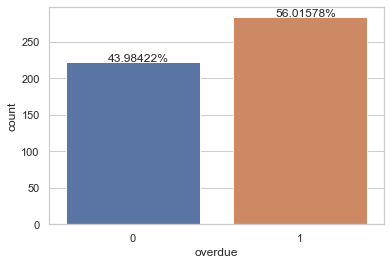

In [99]:
ax = sns.countplot(agents['overdue']);
counts_target = (round(agents['overdue'].value_counts() / agents.shape[0] * 100, ndigits=5)).values[::-1]
for idx, count in zip(ax.patches, counts_target):
    ax.annotate(f'{count}%', (idx.get_x()+0.25, idx.get_height()+0.25))

Значение меток целевой переменной практически равномерно. Выраженного дисбаланса классов не наблюдается.

Ещё раз проверим данные на наличие бесконечных значений по признакам. Если таковые имеются, то удалим эти признаки.

In [100]:
agents.isin([-np.inf, np.inf]).sum()

Sum                                     0
max_ar_bef_01                           0
ar_sum_bef_01                           0
ROA_ncl_bef_02                          0
kfu_bef_03                              0
non_current_assets_diff_bef_03_04       0
accounts_payable_diff_frac_bef_03_04    3
cost_amount_diff_bef_03_04              0
overdue                                 0
dtype: int64

Было бы довольно-таки глупо удалить признак "accounts_payable_diff_frac_bef_03_04" из-за всего трёх бесконечных значений. Заменим эти значения на значение из 99% квантиля.  

Сперва переиндексируем данные и удалим признак "index", который появился вследствие переиндексации.

In [101]:
agents.reset_index(inplace=True)
agents.drop('index', axis=1, inplace=True)

In [102]:
inf_indexes = agents[agents['accounts_payable_diff_frac_bef_03_04'].isin([-np.inf, np.inf])].index
print(inf_indexes)

for inf_index in inf_indexes:
    agents['accounts_payable_diff_frac_bef_03_04'].loc[inf_index] = agents['accounts_payable_diff_frac_bef_03_04']\
    .quantile(0.99)

Int64Index([195, 295, 306], dtype='int64')


Признаки, содержащиеся любую информацию о ПДЗ, не нужны, т.к. для нового контрагента их не будет. Для контагента, с которым ранее взаимодействовали интересна будет информации об исполненных старых обязательствах, динамика изменения внутренних параметров, но и также могут быть интересны и эти признаки. Поэтому выделим в отдельный список все признаки, которые содержат любую информацию о ПДЗ.

In [105]:
list_ar_params = []
for col in agents.columns:
    if 'ar_' in col:
        list_ar_params.append(col)
print(len(list_ar_params))

2


Оценим размерность и признаки, на которых будем обучать модели.

In [106]:
agents.shape

(507, 9)

In [107]:
agents.columns

Index(['Sum', 'max_ar_bef_01', 'ar_sum_bef_01', 'ROA_ncl_bef_02', 'kfu_bef_03',
       'non_current_assets_diff_bef_03_04',
       'accounts_payable_diff_frac_bef_03_04', 'cost_amount_diff_bef_03_04',
       'overdue'],
      dtype='object')

Признаки, которые содержатся в "list_ar_params", будем использовать только совместно с предположением о том, что вся выборка представляет собой контрагентов, с которыми ранее осуществлялось взаимодействие, поэтому по этим признакам накоплена информация.

<h1>6 Обучение модели и интерпретация полученных результатов</h1>

Необходимый функционал данного раздела.

In [108]:
def get_scores(y_true, predictions, metrics):
    
    """
    Функция предназначена для вывод информации о качестве обучения модели.
    Функция принимает следующие параметры:
    y_true: numpy.array / list - верные значения меток целевого признака;
    predictions: numpy.array / list - предсказанные значения меток целевого признака;
    metrics: list - список метрик.
    Функция ничего не возвращает; она выводит на печать значения переданных метрик.
    """
    
    for item in metrics:
        print(f'{item.__name__}: {item(y_true, predictions)}') 

In [109]:
def optimize_hyperparams(trial, x_train, x_valid, y_train, y_valid):
    
    """
    Функция предназначена для оптимизации гиперпараметров модели - градиентного 
    бустинга модуля lightGBM.
    Функция принимает следующие параметры:
    trial: int - количество итераций поиска оптимальных гиперпараметров;
    x_train: pd.DataFrame - тренировочная выборка;
    x_valid: pd.DataFrame - валидационная выборка;
    y_train: np.array / list - тренировочный массив / список целевой переменной;
    y_valid: np.array / list - валидационный массив / список целевой переменной.
    Функция возвращает возвращает значение метрики roc-auc на валидационной выборке.
    """

    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 10, 300, step=1),
        "max_depth": trial.suggest_int("max_depth", 3, 10, step=1),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 200, step=1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10, step=0.1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10, step=0.1)
    }  

    model = LGBMClassifier(objective="binary", **param_grid)
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], eval_metric='roc_auc', early_stopping_rounds=250,
              verbose=-1)
        
    preds = model.predict(x_valid)
                           
    return roc_auc_score(y_valid, preds)

Выделим две группы признаков, которые будут описывать новых контрагентов и контагентов, с которыми ранее было сотрудничество.

In [113]:
agents_old = agents.columns[:8].to_list()
agents_new = [
    col
    for col in agents.columns[:8]
    if col not in list_ar_params
]

['Sum',
 'ROA_ncl_bef_02',
 'kfu_bef_03',
 'non_current_assets_diff_bef_03_04',
 'accounts_payable_diff_frac_bef_03_04',
 'cost_amount_diff_bef_03_04']

Выделим в отдельные переменные данные о целевом признаке - факте ПДЗ - и данные, содержащие все остальные признаки. 

In [114]:
Y = agents['overdue'].values
X_old = agents.loc[:, agents_old]
X_new = agents.loc[:, agents_new]

Разделим данные на тренировочную и валидационную выборки.

In [116]:
np.random.seed(SEED)

x_train_old, x_valid_old, y_train_old, y_valid_old = train_test_split(X_old, Y, test_size=42, shuffle=True,
                                                                      random_state=SEED)

x_train_new, x_valid_new, y_train_new, y_valid_new = train_test_split(X_new, Y, test_size=42, shuffle=True, 
                                                                      random_state=SEED)

В качестве основной модели был выбран градиентный бустинг модуля lightGBM.  
Качество модели оценивается по метрике "roc-auc". Метрика "accuracy" здесь носит чисто информативный характер.

Обучать модель будем сразу через подбор гиперпараметров.

## 6.1 Обучим модель на данных, предполагая, что имеем дело со старыми контрагентами

Обучим модель на полном исходном множестве признаков.

In [118]:
np.random.seed(SEED)

study1_old = optuna.create_study(direction="maximize", study_name="LGBM1_old")
func1_old = lambda trial: optimize_hyperparams(trial, x_train_old, x_valid_old, y_train_old, y_valid_old)
study1_old.optimize(func1_old, n_trials=300, show_progress_bar=True)

[I 2022-03-19 17:23:59,252] A new study created in memory with name: LGBM1_old


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[506]	valid_0's binary_logloss: 0.614822
[I 2022-03-19 17:23:59,678] Trial 0 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 600, 'learning_rate': 0.23445765570122007, 'num_leaves': 281, 'max_depth': 10, 'min_child_samples': 185, 'reg_alpha': 8.9, 'reg_lambda': 7.0}. Best is trial 0 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.641691
[I 2022-03-19 17:23:59,836] Trial 1 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 250, 'learning_rate': 0.25200630393944223, 'num_leaves': 245, 'max_depth': 5, 'min_child_samples': 8, 'reg_alpha': 8.1, 'reg_lambda': 3.1}. Best is trial 0 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[17]	

Early stopping, best iteration is:
[271]	valid_0's binary_logloss: 0.611923
[I 2022-03-19 17:24:04,424] Trial 18 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 600, 'learning_rate': 0.297752039673302, 'num_leaves': 296, 'max_depth': 6, 'min_child_samples': 180, 'reg_alpha': 8.4, 'reg_lambda': 5.0}. Best is trial 13 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[394]	valid_0's binary_logloss: 0.604734
[I 2022-03-19 17:24:04,610] Trial 19 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 400, 'learning_rate': 0.15296335444147505, 'num_leaves': 211, 'max_depth': 9, 'min_child_samples': 200, 'reg_alpha': 2.0, 'reg_lambda': 3.6}. Best is trial 19 with value: 0.7562929061784898.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's binary_logloss: 0.603246
[I 2022-03-19 17:24:04,

Did not meet early stopping. Best iteration is:
[350]	valid_0's binary_logloss: 0.613702
[I 2022-03-19 17:24:07,593] Trial 36 finished with value: 0.7345537757437071 and parameters: {'n_estimators': 350, 'learning_rate': 0.17587845177342445, 'num_leaves': 242, 'max_depth': 7, 'min_child_samples': 198, 'reg_alpha': 4.1000000000000005, 'reg_lambda': 0.0}. Best is trial 22 with value: 0.7780320366132722.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's binary_logloss: 0.61023
[I 2022-03-19 17:24:07,779] Trial 37 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 200, 'learning_rate': 0.09259539922750727, 'num_leaves': 299, 'max_depth': 8, 'min_child_samples': 142, 'reg_alpha': 2.5, 'reg_lambda': 1.7000000000000002}. Best is trial 22 with value: 0.7780320366132722.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[175]	valid_0's bina

Did not meet early stopping. Best iteration is:
[447]	valid_0's binary_logloss: 0.60561
[I 2022-03-19 17:24:11,234] Trial 54 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 450, 'learning_rate': 0.1415732919244755, 'num_leaves': 273, 'max_depth': 9, 'min_child_samples': 200, 'reg_alpha': 2.2, 'reg_lambda': 3.5}. Best is trial 41 with value: 0.782608695652174.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[648]	valid_0's binary_logloss: 0.604547
[I 2022-03-19 17:24:11,503] Trial 55 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 650, 'learning_rate': 0.1446705479269451, 'num_leaves': 208, 'max_depth': 9, 'min_child_samples': 194, 'reg_alpha': 2.1, 'reg_lambda': 3.5}. Best is trial 41 with value: 0.782608695652174.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[649]	valid_0's binary_logloss: 0.606217
[I 2022-03-1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's binary_logloss: 0.586762
[I 2022-03-19 17:24:15,946] Trial 72 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 400, 'learning_rate': 0.1836187326354021, 'num_leaves': 142, 'max_depth': 10, 'min_child_samples': 183, 'reg_alpha': 2.4000000000000004, 'reg_lambda': 4.7}. Best is trial 41 with value: 0.782608695652174.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[549]	valid_0's binary_logloss: 0.577878
[I 2022-03-19 17:24:16,285] Trial 73 finished with value: 0.799771167048055 and parameters: {'n_estimators': 550, 'learning_rate': 0.2682950448956076, 'num_leaves': 194, 'max_depth': 6, 'min_child_samples': 189, 'reg_alpha': 0.4, 'reg_lambda': 2.4000000000000004}. Best is trial 73 with value: 0.799771167048055.
Training until validation scores don't improve for 250 rounds
Did not 

Did not meet early stopping. Best iteration is:
[573]	valid_0's binary_logloss: 0.57689
[I 2022-03-19 17:24:20,859] Trial 89 finished with value: 0.799771167048055 and parameters: {'n_estimators': 600, 'learning_rate': 0.25480416743526485, 'num_leaves': 224, 'max_depth': 6, 'min_child_samples': 178, 'reg_alpha': 0.0, 'reg_lambda': 3.3000000000000003}. Best is trial 74 with value: 0.8043478260869565.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[547]	valid_0's binary_logloss: 0.578147
[I 2022-03-19 17:24:21,236] Trial 90 finished with value: 0.799771167048055 and parameters: {'n_estimators': 550, 'learning_rate': 0.2565994831048482, 'num_leaves': 215, 'max_depth': 6, 'min_child_samples': 178, 'reg_alpha': 0.1, 'reg_lambda': 4.4}. Best is trial 74 with value: 0.8043478260869565.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[550]	valid_0's binary_logloss: 0.583

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.603514
[I 2022-03-19 17:24:27,475] Trial 107 finished with value: 0.6601830663615561 and parameters: {'n_estimators': 600, 'learning_rate': 0.2645518979598856, 'num_leaves': 234, 'max_depth': 6, 'min_child_samples': 153, 'reg_alpha': 4.7, 'reg_lambda': 4.800000000000001}. Best is trial 74 with value: 0.8043478260869565.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[524]	valid_0's binary_logloss: 0.576522
[I 2022-03-19 17:24:27,961] Trial 108 finished with value: 0.7780320366132722 and parameters: {'n_estimators': 550, 'learning_rate': 0.28591472742938556, 'num_leaves': 226, 'max_depth': 5, 'min_child_samples': 173, 'reg_alpha': 0.1, 'reg_lambda': 4.4}. Best is trial 74 with value: 0.8043478260869565.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.611239
[I 2022-03-19 17:24:33,978] Trial 125 finished with value: 0.6601830663615561 and parameters: {'n_estimators': 600, 'learning_rate': 0.24033568044676146, 'num_leaves': 224, 'max_depth': 6, 'min_child_samples': 42, 'reg_alpha': 0.2, 'reg_lambda': 5.300000000000001}. Best is trial 74 with value: 0.8043478260869565.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[799]	valid_0's binary_logloss: 0.59432
[I 2022-03-19 17:24:34,320] Trial 126 finished with value: 0.8043478260869565 and parameters: {'n_estimators': 800, 'learning_rate': 0.2943562005754662, 'num_leaves': 179, 'max_depth': 5, 'min_child_samples': 190, 'reg_alpha': 0.9, 'reg_lambda': 4.4}. Best is trial 74 with value: 0.8043478260869565.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:


Did not meet early stopping. Best iteration is:
[849]	valid_0's binary_logloss: 0.601914
[I 2022-03-19 17:24:40,098] Trial 143 finished with value: 0.7780320366132722 and parameters: {'n_estimators': 850, 'learning_rate': 0.286807087792155, 'num_leaves': 176, 'max_depth': 7, 'min_child_samples': 197, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 7.7}. Best is trial 74 with value: 0.8043478260869565.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.583912
[I 2022-03-19 17:24:40,356] Trial 144 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 850, 'learning_rate': 0.2556970600330121, 'num_leaves': 172, 'max_depth': 7, 'min_child_samples': 185, 'reg_alpha': 1.0, 'reg_lambda': 6.7}. Best is trial 74 with value: 0.8043478260869565.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[796]	valid_0's binary_logloss: 0.595617
[I 202

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's binary_logloss: 0.596888
[I 2022-03-19 17:24:46,184] Trial 161 finished with value: 0.8043478260869565 and parameters: {'n_estimators': 1000, 'learning_rate': 0.26752856187443114, 'num_leaves': 175, 'max_depth': 8, 'min_child_samples': 190, 'reg_alpha': 1.1, 'reg_lambda': 9.5}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's binary_logloss: 0.597562
[I 2022-03-19 17:24:46,568] Trial 162 finished with value: 0.7780320366132722 and parameters: {'n_estimators': 1000, 'learning_rate': 0.27863749875339017, 'num_leaves': 157, 'max_depth': 8, 'min_child_samples': 200, 'reg_alpha': 1.1, 'reg_lambda': 9.8}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping.

Early stopping, best iteration is:
[213]	valid_0's binary_logloss: 0.583859
[I 2022-03-19 17:24:52,394] Trial 179 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 900, 'learning_rate': 0.25742510479247926, 'num_leaves': 147, 'max_depth': 8, 'min_child_samples': 182, 'reg_alpha': 1.0, 'reg_lambda': 7.6000000000000005}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.614545
[I 2022-03-19 17:24:52,729] Trial 180 finished with value: 0.7345537757437071 and parameters: {'n_estimators': 950, 'learning_rate': 0.29349245540123986, 'num_leaves': 155, 'max_depth': 8, 'min_child_samples': 192, 'reg_alpha': 4.5, 'reg_lambda': 9.3}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[860]	valid_0's binary_logloss: 0.59454
[I 2022-03-19 1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[741]	valid_0's binary_logloss: 0.576856
[I 2022-03-19 17:25:01,011] Trial 197 finished with value: 0.799771167048055 and parameters: {'n_estimators': 800, 'learning_rate': 0.27532955917751323, 'num_leaves': 198, 'max_depth': 5, 'min_child_samples': 189, 'reg_alpha': 0.5, 'reg_lambda': 9.9}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[188]	valid_0's binary_logloss: 0.583884
[I 2022-03-19 17:25:01,315] Trial 198 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 800, 'learning_rate': 0.29814131688442536, 'num_leaves': 187, 'max_depth': 7, 'min_child_samples': 185, 'reg_alpha': 1.0, 'reg_lambda': 5.800000000000001}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. B

Did not meet early stopping. Best iteration is:
[850]	valid_0's binary_logloss: 0.585166
[I 2022-03-19 17:25:10,066] Trial 215 finished with value: 0.7780320366132722 and parameters: {'n_estimators': 850, 'learning_rate': 0.2892848495334506, 'num_leaves': 151, 'max_depth': 7, 'min_child_samples': 194, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 6.9}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[849]	valid_0's binary_logloss: 0.594006
[I 2022-03-19 17:25:10,655] Trial 216 finished with value: 0.8043478260869565 and parameters: {'n_estimators': 850, 'learning_rate': 0.29107362558419314, 'num_leaves': 173, 'max_depth': 7, 'min_child_samples': 200, 'reg_alpha': 0.8, 'reg_lambda': 5.6000000000000005}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[181]	valid_0's binary_logl

Did not meet early stopping. Best iteration is:
[949]	valid_0's binary_logloss: 0.601087
[I 2022-03-19 17:25:25,387] Trial 250 finished with value: 0.8043478260869565 and parameters: {'n_estimators': 950, 'learning_rate': 0.27813929930677067, 'num_leaves': 101, 'max_depth': 8, 'min_child_samples': 197, 'reg_alpha': 1.3, 'reg_lambda': 8.1}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[849]	valid_0's binary_logloss: 0.589063
[I 2022-03-19 17:25:25,771] Trial 251 finished with value: 0.7517162471395882 and parameters: {'n_estimators': 850, 'learning_rate': 0.2755124632340272, 'num_leaves': 203, 'max_depth': 5, 'min_child_samples': 197, 'reg_alpha': 0.1, 'reg_lambda': 5.5}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[900]	valid_0's binary_logloss: 0.597941
[I 2

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[257]	valid_0's binary_logloss: 0.641018
[I 2022-03-19 17:25:39,827] Trial 286 finished with value: 0.6475972540045767 and parameters: {'n_estimators': 1000, 'learning_rate': 0.2943532452451948, 'num_leaves': 190, 'max_depth': 7, 'min_child_samples': 193, 'reg_alpha': 9.5, 'reg_lambda': 7.0}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.584672
[I 2022-03-19 17:25:40,047] Trial 287 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 1000, 'learning_rate': 0.29339301493360015, 'num_leaves': 163, 'max_depth': 8, 'min_child_samples': 187, 'reg_alpha': 1.2000000000000002, 'reg_lambda': 8.4}. Best is trial 146 with value: 0.8260869565217391.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iterat

Посмотрим на лучший скор и на найденные параметры.

In [119]:
print(study1_old.best_value)
study1_old.best_params

0.8260869565217391


{'n_estimators': 950,
 'learning_rate': 0.29605756504385783,
 'num_leaves': 159,
 'max_depth': 7,
 'min_child_samples': 191,
 'reg_alpha': 0.6000000000000001,
 'reg_lambda': 6.7}

Визуализируем динамику обучения модели.

In [120]:
scores1 = [
    study1_old.trials[i].values[0]
    for i in range(len(study1_old.trials))
]

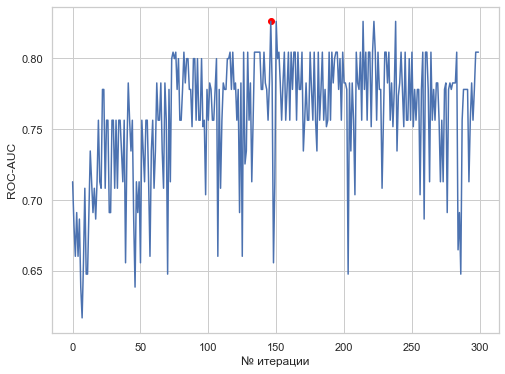

In [122]:
plt.figure(figsize=(8, 6))
plt.plot(scores1)
plt.scatter(scores1.index(study1_old.best_value), study1_old.best_value, color='red')
plt.xlabel('№ итерации')
plt.ylabel('ROC-AUC')
plt.plot();

Сохраним параметры модели и взглянем на метрики ещё раз.

In [123]:
np.random.seed(SEED)

model_params1_old = study1_old.best_params
model1_old = LGBMClassifier(objective="binary", **model_params1_old)

model1_old.fit(x_train_old, y_train_old)
get_scores(y_valid_old, model1_old.predict(x_valid_old), metrics=metrics)

accuracy_score: 0.8095238095238095
roc_auc_score: 0.8260869565217391


Значение метрики "roc-auc" на тесте равна 0.82609.  
Доля верных ответов (accuracy) составила 80.95238%.

Посмотрим на важность признаков.

In [124]:
np.random.seed(SEED)

perm1_old = PermutationImportance(model1_old, random_state=SEED).fit(x_valid_old, y_valid_old)
eli5.show_weights(perm1_old, feature_names=list(x_valid_old))

Weight,Feature
0.1381 ± 0.0356,Sum
0.1000 ± 0.1061,kfu_bef_03
0.0905 ± 0.0819,ar_sum_bef_01
0.0810 ± 0.0571,ROA_ncl_bef_02
0.0762 ± 0.0555,non_current_assets_diff_bef_03_04
0.0667 ± 0.0555,cost_amount_diff_bef_03_04
0.0667 ± 0.0356,accounts_payable_diff_frac_bef_03_04
0.0238 ± 0.0426,max_ar_bef_01


Наиболее значимым признаком для модели, обученной на полном множестве отобранных признаков, получился признак "Sum" (сумма факторых признаков). Примерно одинаковую значимость имеют три параметра 
- non_current_assets_diff_bef_03_04 (абсолютное изменнение оборотных активов -3 года к -4)
- cost_amount_diff_bef_03_04 (абсолютное изменение себестоимости -3 года к -4)
- accounts_payable_diff_frac_bef_03_04 (относительное изменение кредиторской задолженности -3 года к -4)
 
Малозначимым оказался параметр 
- max_ar_bef_01 (максимальнапя просрочка дней, за прошлый год)

Его значения слабо влияют на предсказания модели.

Построрим график влияния каждого признака на предсказания факта ПДЗ.

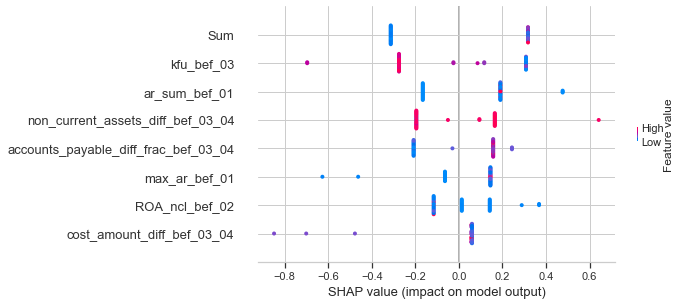

In [125]:
np.random.seed(SEED)

explainer1_old = shap.TreeExplainer(model1_old)
shap_values1_old = explainer1_old.shap_values(x_valid_old)
shap.summary_plot(shap_values1_old[1], x_valid_old)

Единичные значения на графике могут являться выбросами и в большинстве своём нерелевантны для модели; они только ухудшают её предсказания.

Из графика видно, что высокие значения "kfu_bef_03" (коэффициента финансовой устойчивости, за -3 год, относительно текущего), и малые значения "Sum" имеет негативный характер влияния на предсказания модели. Чем меньше "kfu_bef_03", тем более точнее получим предсказание. Аналогичное верное и для "Sum", но только в диаметрально противоположном направлении. Для более точного предсказания нужно, чтобы сумма рассчитывалась как можно на более полных факторных признаков, т.е. чем меньше пропусков, тем лучше.

Признак "cost_amount_diff_bef_03_04" (абсолютное отклонение себестоимости -3 года к -4, относительно текущего) положительно влияет на предсказания модели, т.е. все релевантные значения расположены справа от нуля.

Остальные признаки в большинстве своём положительно влияют на предсказания модели только благодаря взаимодействую с другими признаками. Можно сказать, что в пространстве признаков, описывающем старых контрагентов, присутствует синергия между признаками, на которых была обучена модель.

Попробуем обучить модель на первых семи признаков, которые показали себя самыми значимыми для модели.

In [128]:
selected_old_cols = ['Sum','ar_sum_bef_01', 'ROA_ncl_bef_02', 'kfu_bef_03', 'non_current_assets_diff_bef_03_04',
                'accounts_payable_diff_frac_bef_03_04', 'cost_amount_diff_bef_03_04']

x_train_old6 = x_train_old.loc[:, selected_old_cols]
x_valid_old6 = x_valid_old.loc[:, selected_old_cols]

In [129]:
np.random.seed(SEED)

study2_old = optuna.create_study(direction="maximize", study_name="LGBM2_old")
func2_old = lambda trial: optimize_hyperparams(trial, x_train_old6, x_valid_old6, y_train_old, y_valid_old)
study2_old.optimize(func2_old, n_trials=300, show_progress_bar=True)

[I 2022-03-19 17:55:19,101] A new study created in memory with name: LGBM2_old


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[363]	valid_0's binary_logloss: 0.59729
[I 2022-03-19 17:55:19,386] Trial 0 finished with value: 0.6601830663615561 and parameters: {'n_estimators': 400, 'learning_rate': 0.1668680171606927, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 134, 'reg_alpha': 1.9000000000000001, 'reg_lambda': 0.7000000000000001}. Best is trial 0 with value: 0.6601830663615561.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[441]	valid_0's binary_logloss: 0.597051
[I 2022-03-19 17:55:19,642] Trial 1 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 850, 'learning_rate': 0.25253361644036737, 'num_leaves': 273, 'max_depth': 3, 'min_child_samples': 164, 'reg_alpha': 5.4, 'reg_lambda': 8.9}. Best is trial 1 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Early stopping, best ite

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.632364
[I 2022-03-19 17:55:23,894] Trial 19 finished with value: 0.6910755148741419 and parameters: {'n_estimators': 300, 'learning_rate': 0.21411887483481032, 'num_leaves': 153, 'max_depth': 6, 'min_child_samples': 199, 'reg_alpha': 8.3, 'reg_lambda': 4.4}. Best is trial 1 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[250]	valid_0's binary_logloss: 0.612196
[I 2022-03-19 17:55:24,050] Trial 20 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 250, 'learning_rate': 0.14587880210880655, 'num_leaves': 233, 'max_depth': 4, 'min_child_samples': 166, 'reg_alpha': 8.700000000000001, 'reg_lambda': 2.2}. Best is trial 1 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Did not meet early sto

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[250]	valid_0's binary_logloss: 0.620552
[I 2022-03-19 17:55:27,187] Trial 37 finished with value: 0.6910755148741419 and parameters: {'n_estimators': 250, 'learning_rate': 0.09425602032717684, 'num_leaves': 239, 'max_depth': 4, 'min_child_samples': 158, 'reg_alpha': 10.0, 'reg_lambda': 0.7000000000000001}. Best is trial 1 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[250]	valid_0's binary_logloss: 0.618999
[I 2022-03-19 17:55:27,458] Trial 38 finished with value: 0.6910755148741419 and parameters: {'n_estimators': 250, 'learning_rate': 0.0511231807217744, 'num_leaves': 280, 'max_depth': 5, 'min_child_samples': 163, 'reg_alpha': 9.200000000000001, 'reg_lambda': 7.4}. Best is trial 1 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Did not

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.618526
[I 2022-03-19 17:55:31,372] Trial 55 finished with value: 0.6910755148741419 and parameters: {'n_estimators': 200, 'learning_rate': 0.05167233919737086, 'num_leaves': 261, 'max_depth': 5, 'min_child_samples': 149, 'reg_alpha': 8.9, 'reg_lambda': 0.6000000000000001}. Best is trial 1 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[128]	valid_0's binary_logloss: 0.617685
[I 2022-03-19 17:55:31,638] Trial 56 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 350, 'learning_rate': 0.07983732355407641, 'num_leaves': 215, 'max_depth': 7, 'min_child_samples': 124, 'reg_alpha': 8.3, 'reg_lambda': 0.4}. Best is trial 1 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Early stopping, best 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[350]	valid_0's binary_logloss: 0.603465
[I 2022-03-19 17:55:35,090] Trial 74 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 350, 'learning_rate': 0.1102670942184722, 'num_leaves': 131, 'max_depth': 5, 'min_child_samples': 180, 'reg_alpha': 7.2, 'reg_lambda': 1.7000000000000002}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[350]	valid_0's binary_logloss: 0.626057
[I 2022-03-19 17:55:35,249] Trial 75 finished with value: 0.6910755148741419 and parameters: {'n_estimators': 350, 'learning_rate': 0.057707748086101754, 'num_leaves': 140, 'max_depth': 8, 'min_child_samples': 200, 'reg_alpha': 7.2, 'reg_lambda': 0.30000000000000004}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Did

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[322]	valid_0's binary_logloss: 0.618076
[I 2022-03-19 17:55:38,896] Trial 92 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 400, 'learning_rate': 0.29809875745776104, 'num_leaves': 114, 'max_depth': 3, 'min_child_samples': 190, 'reg_alpha': 5.9, 'reg_lambda': 8.1}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[63]	valid_0's binary_logloss: 0.610622
[I 2022-03-19 17:55:39,105] Trial 93 finished with value: 0.6864988558352403 and parameters: {'n_estimators': 150, 'learning_rate': 0.13277237942527553, 'num_leaves': 209, 'max_depth': 4, 'min_child_samples': 104, 'reg_alpha': 7.4, 'reg_lambda': 3.8000000000000003}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best

Did not meet early stopping. Best iteration is:
[750]	valid_0's binary_logloss: 0.596864
[I 2022-03-19 17:55:43,247] Trial 110 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 750, 'learning_rate': 0.01439920493322086, 'num_leaves': 157, 'max_depth': 6, 'min_child_samples': 188, 'reg_alpha': 4.800000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[800]	valid_0's binary_logloss: 0.667124
[I 2022-03-19 17:55:43,654] Trial 111 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 800, 'learning_rate': 0.0019748742771038465, 'num_leaves': 157, 'max_depth': 6, 'min_child_samples': 194, 'reg_alpha': 4.9, 'reg_lambda': 1.1}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[274]	valid_0'

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.606527
[I 2022-03-19 17:55:47,858] Trial 128 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 950, 'learning_rate': 0.037082237540171085, 'num_leaves': 143, 'max_depth': 6, 'min_child_samples': 95, 'reg_alpha': 0.8, 'reg_lambda': 4.9}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[209]	valid_0's binary_logloss: 0.617834
[I 2022-03-19 17:55:48,204] Trial 129 finished with value: 0.6647597254004577 and parameters: {'n_estimators': 750, 'learning_rate': 0.029119111338835837, 'num_leaves': 184, 'max_depth': 6, 'min_child_samples': 79, 'reg_alpha': 7.4, 'reg_lambda': 0.9}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[236]	valid_0's binary_

Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.609707
[I 2022-03-19 17:55:53,570] Trial 146 finished with value: 0.6864988558352403 and parameters: {'n_estimators': 1000, 'learning_rate': 0.032150188710728715, 'num_leaves': 144, 'max_depth': 5, 'min_child_samples': 95, 'reg_alpha': 7.300000000000001, 'reg_lambda': 2.8000000000000003}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[208]	valid_0's binary_logloss: 0.6032
[I 2022-03-19 17:55:53,800] Trial 147 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 950, 'learning_rate': 0.033858893786886134, 'num_leaves': 153, 'max_depth': 6, 'min_child_samples': 103, 'reg_alpha': 4.1000000000000005, 'reg_lambda': 0.2}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.604732


[I 2022-03-19 17:55:58,956] Trial 164 finished with value: 0.7345537757437071 and parameters: {'n_estimators': 1000, 'learning_rate': 0.04815772709558954, 'num_leaves': 89, 'max_depth': 6, 'min_child_samples': 97, 'reg_alpha': 8.200000000000001, 'reg_lambda': 0.5}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.607835
[I 2022-03-19 17:55:59,129] Trial 165 finished with value: 0.7345537757437071 and parameters: {'n_estimators': 1000, 'learning_rate': 0.04736291781709577, 'num_leaves': 85, 'max_depth': 6, 'min_child_samples': 98, 'reg_alpha': 8.200000000000001, 'reg_lambda': 0.6000000000000001}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.608269
[I 2022-03-19 17:55:59,349] Trial 166 finished with value: 0.7128146453089245 a

Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.611144
[I 2022-03-19 17:56:03,761] Trial 182 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 950, 'learning_rate': 0.0686580794094502, 'num_leaves': 32, 'max_depth': 6, 'min_child_samples': 94, 'reg_alpha': 7.5, 'reg_lambda': 0.0}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[238]	valid_0's binary_logloss: 0.613256
[I 2022-03-19 17:56:03,977] Trial 183 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03716877618642995, 'num_leaves': 64, 'max_depth': 6, 'min_child_samples': 91, 'reg_alpha': 7.9, 'reg_lambda': 0.2}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[550]	valid_0's binary_logloss: 0.608896
[I 2022-03-19 17:56:04,276] Trial 184 finished w

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[582]	valid_0's binary_logloss: 0.603637
[I 2022-03-19 17:56:10,079] Trial 200 finished with value: 0.6693363844393592 and parameters: {'n_estimators': 1000, 'learning_rate': 0.014861502523502206, 'num_leaves': 180, 'max_depth': 6, 'min_child_samples': 84, 'reg_alpha': 7.5, 'reg_lambda': 0.0}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[279]	valid_0's binary_logloss: 0.611428
[I 2022-03-19 17:56:10,291] Trial 201 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 1000, 'learning_rate': 0.030605018621333385, 'num_leaves': 54, 'max_depth': 7, 'min_child_samples': 94, 'reg_alpha': 7.7, 'reg_lambda': 0.2}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[167]	valid_0's binary

Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.607914
[I 2022-03-19 17:56:13,946] Trial 218 finished with value: 0.6864988558352403 and parameters: {'n_estimators': 1000, 'learning_rate': 0.021867076836464914, 'num_leaves': 68, 'max_depth': 8, 'min_child_samples': 36, 'reg_alpha': 7.9, 'reg_lambda': 0.4}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.610086
[I 2022-03-19 17:56:14,242] Trial 219 finished with value: 0.6864988558352403 and parameters: {'n_estimators': 1000, 'learning_rate': 0.026236364665584953, 'num_leaves': 182, 'max_depth': 6, 'min_child_samples': 106, 'reg_alpha': 7.4, 'reg_lambda': 0.2}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.602639
[I 2022-03-19 17:56:14,480] Trial 220 fini

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.609038
[I 2022-03-19 17:56:18,452] Trial 236 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 1000, 'learning_rate': 0.048505271355136055, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 108, 'reg_alpha': 7.7, 'reg_lambda': 0.8}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[281]	valid_0's binary_logloss: 0.610958
[I 2022-03-19 17:56:18,719] Trial 237 finished with value: 0.6864988558352403 and parameters: {'n_estimators': 950, 'learning_rate': 0.024029616121371652, 'num_leaves': 183, 'max_depth': 6, 'min_child_samples': 93, 'reg_alpha': 4.1000000000000005, 'reg_lambda': 0.2}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[311]	v

[I 2022-03-19 17:56:22,564] Trial 254 finished with value: 0.7345537757437071 and parameters: {'n_estimators': 250, 'learning_rate': 0.028684103062999948, 'num_leaves': 103, 'max_depth': 6, 'min_child_samples': 97, 'reg_alpha': 3.8000000000000003, 'reg_lambda': 2.2}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.611559
[I 2022-03-19 17:56:22,747] Trial 255 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 300, 'learning_rate': 0.014301157196772635, 'num_leaves': 99, 'max_depth': 6, 'min_child_samples': 97, 'reg_alpha': 7.6000000000000005, 'reg_lambda': 0.30000000000000004}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[250]	valid_0's binary_logloss: 0.612873
[I 2022-03-19 17:56:22,933] Trial 256 finished wi

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[179]	valid_0's binary_logloss: 0.612126
[I 2022-03-19 17:56:26,637] Trial 272 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 1000, 'learning_rate': 0.045420841995777235, 'num_leaves': 71, 'max_depth': 9, 'min_child_samples': 91, 'reg_alpha': 7.5, 'reg_lambda': 0.1}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.610841
[I 2022-03-19 17:56:26,845] Trial 273 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 900, 'learning_rate': 0.10604923436369151, 'num_leaves': 67, 'max_depth': 7, 'min_child_samples': 101, 'reg_alpha': 9.0, 'reg_lambda': 4.5}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[324]	valid_0's binary_l

Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 0.6108
[I 2022-03-19 17:56:30,758] Trial 290 finished with value: 0.6864988558352403 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03724643027687333, 'num_leaves': 169, 'max_depth': 6, 'min_child_samples': 92, 'reg_alpha': 4.4, 'reg_lambda': 0.30000000000000004}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.608823
[I 2022-03-19 17:56:30,933] Trial 291 finished with value: 0.7128146453089245 and parameters: {'n_estimators': 450, 'learning_rate': 0.09756046327331089, 'num_leaves': 95, 'max_depth': 6, 'min_child_samples': 109, 'reg_alpha': 8.0, 'reg_lambda': 0.7000000000000001}. Best is trial 63 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.604296
[I 2022-03-19 17:5

Посмотрим на лучший скор и на найденные параметры.

In [132]:
print(study2_old.best_value)
study2_old.best_params

0.7345537757437071


{'n_estimators': 550,
 'learning_rate': 0.1958258989738664,
 'num_leaves': 136,
 'max_depth': 3,
 'min_child_samples': 196,
 'reg_alpha': 5.1000000000000005,
 'reg_lambda': 4.800000000000001}

Визуализируем динамику обучения модели.

In [133]:
scores2 = [
    study2_old.trials[i].values[0]
    for i in range(len(study2_old.trials))
]

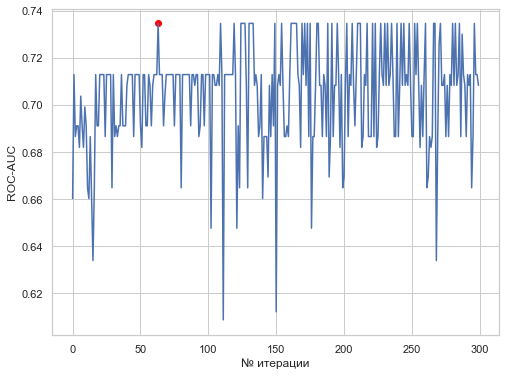

In [134]:
plt.figure(figsize=(8, 6))
plt.plot(scores2)
plt.scatter(scores2.index(study2_old.best_value), study2_old.best_value, color='red')
plt.xlabel('№ итерации')
plt.ylabel('ROC-AUC')
plt.plot();

Сохраним параметры модели и взглянем на метрики ещё раз.

In [135]:
np.random.seed(SEED)

model_params2_old = study2_old.best_params
model2_old = LGBMClassifier(objective="binary", **model_params2_old)

model2_old.fit(x_train_old6, y_train_old)
get_scores(y_valid_old, model2_old.predict(x_valid_old6), metrics=metrics)

accuracy_score: 0.7142857142857143
roc_auc_score: 0.7345537757437071


Значение метрики "roc-auc" на тесте снизилось до равна 0.73455.  
Доля верных ответов (accuracy) также упала и составила 71.42857%.

Посмотрим, как изменились важность признаков и график влияния признаков на предсказания модели.

In [136]:
np.random.seed(SEED)

perm2_old = PermutationImportance(model2_old, random_state=SEED).fit(x_valid_old6, y_valid_old)
eli5.show_weights(perm2_old, feature_names=list(x_valid_old6))

Weight,Feature
0.1000 ± 0.0819,ar_sum_bef_01
0.0857 ± 0.0646,Sum
0.0476 ± 0.0426,accounts_payable_diff_frac_bef_03_04
0.0286 ± 0.0632,non_current_assets_diff_bef_03_04
0.0048 ± 0.0190,cost_amount_diff_bef_03_04
0.0000 ± 0.0602,kfu_bef_03
0 ± 0.0000,ROA_ncl_bef_02


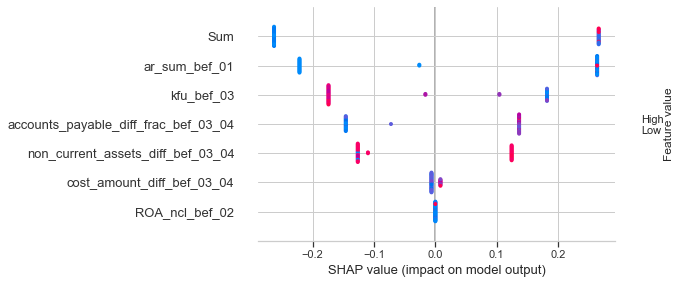

In [137]:
np.random.seed(SEED)

explainer2_old = shap.TreeExplainer(model2_old)
shap_values2_old = explainer2_old.shap_values(x_valid_old6)
shap.summary_plot(shap_values2_old[1], x_valid_old6)

Картина в данном случае глобально изменилась.  
Теперь имеем три признака, которые полностью не влияют на предсказания модели. Это три самых последних признака, которые представлены в таблице важности признаков.  
Изменился самый важный признак. Теперь это признак - "ar_sum_bef_01" (обзая сумма ПДЗ свыше 5 дней, за прошлый год). Он увеличил свою значимость для модели, что нельзя сказать про другие признаки.  
Сильно ухудшилось значимость признака сумма факторных признаков.  
В целом, расположение точек на графике отсалось таким же. Изменился лишь масштаб, но это связано с дропом признака "max_ar_bef_01" (максимальная ПДЗ, дней за прошлый год).  
**Таким образом, дропнув лишь один параметр, лишись синергии признаков, потеряли половину признаков, которые ранее имели значительное влияние на предсказание модели, проиграли по доле верных ответов и метрике roc-auc.**

**Вывод:**
- для предсказания факта ПДЗ по старым контагентам необходимо использовать все отобранные признаки, потому что они отлично дополняют друг друга, создавая синергетический эффект.

## 6.2 Обучим модель на данных, предполагая, что имеем дело с новыми контрагентами

In [138]:
np.random.seed(SEED)

study1_new = optuna.create_study(direction="maximize", study_name="LGBM1_new")
func1_new = lambda trial: optimize_hyperparams(trial, x_train_new, x_valid_new, y_train_new, y_valid_new)
study1_new.optimize(func1_new, n_trials=300, show_progress_bar=True)

[I 2022-03-19 18:17:40,123] A new study created in memory with name: LGBM1_new


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.634441
[I 2022-03-19 18:17:40,320] Trial 0 finished with value: 0.6338672768878719 and parameters: {'n_estimators': 900, 'learning_rate': 0.19673771004038992, 'num_leaves': 28, 'max_depth': 5, 'min_child_samples': 116, 'reg_alpha': 3.6, 'reg_lambda': 3.7}. Best is trial 0 with value: 0.6338672768878719.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[449]	valid_0's binary_logloss: 0.617505
[I 2022-03-19 18:17:40,509] Trial 1 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 450, 'learning_rate': 0.15167808330691976, 'num_leaves': 41, 'max_depth': 5, 'min_child_samples': 177, 'reg_alpha': 3.6, 'reg_lambda': 6.5}. Best is trial 1 with value: 0.6819221967963386.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[30]	valid_0's bina

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.634506
[I 2022-03-19 18:17:44,379] Trial 18 finished with value: 0.6075514874141876 and parameters: {'n_estimators': 650, 'learning_rate': 0.28064986824269866, 'num_leaves': 53, 'max_depth': 8, 'min_child_samples': 79, 'reg_alpha': 5.300000000000001, 'reg_lambda': 2.2}. Best is trial 1 with value: 0.6819221967963386.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[366]	valid_0's binary_logloss: 0.64135
[I 2022-03-19 18:17:44,598] Trial 19 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 800, 'learning_rate': 0.2579502650727776, 'num_leaves': 126, 'max_depth': 4, 'min_child_samples': 199, 'reg_alpha': 4.3, 'reg_lambda': 9.700000000000001}. Best is trial 1 with value: 0.6819221967963386.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best itera

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.626286
[I 2022-03-19 18:17:47,944] Trial 36 finished with value: 0.6647597254004577 and parameters: {'n_estimators': 300, 'learning_rate': 0.1509732793291613, 'num_leaves': 225, 'max_depth': 6, 'min_child_samples': 35, 'reg_alpha': 1.9000000000000001, 'reg_lambda': 0.1}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.620954
[I 2022-03-19 18:17:48,093] Trial 37 finished with value: 0.602974828375286 and parameters: {'n_estimators': 450, 'learning_rate': 0.16617931126081423, 'num_leaves': 205, 'max_depth': 4, 'min_child_samples': 64, 'reg_alpha': 3.1, 'reg_lambda': 3.0}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's binary_logloss: 0.641451
[I 2022-03-19 18:17:48,22

[I 2022-03-19 18:17:51,520] Trial 54 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 350, 'learning_rate': 0.16707654100078329, 'num_leaves': 298, 'max_depth': 6, 'min_child_samples': 190, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 8.4}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[398]	valid_0's binary_logloss: 0.609436
[I 2022-03-19 18:17:51,742] Trial 55 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 400, 'learning_rate': 0.11904862100159797, 'num_leaves': 300, 'max_depth': 6, 'min_child_samples': 189, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 8.6}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.635514
[I 2022-03-19 18:17:52,019] Trial 56 finished with value: 0.6773455377574371 and

[I 2022-03-19 18:17:56,231] Trial 72 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 800, 'learning_rate': 0.09938584824790853, 'num_leaves': 180, 'max_depth': 8, 'min_child_samples': 59, 'reg_alpha': 0.8, 'reg_lambda': 10.0}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[741]	valid_0's binary_logloss: 0.629325
[I 2022-03-19 18:17:56,535] Trial 73 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 750, 'learning_rate': 0.08320594201532001, 'num_leaves': 258, 'max_depth': 8, 'min_child_samples': 194, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 9.700000000000001}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[346]	valid_0's binary_logloss: 0.608763
[I 2022-03-19 18:17:56,719] Trial 74 finished with value: 0.6601830

Did not meet early stopping. Best iteration is:
[748]	valid_0's binary_logloss: 0.629428
[I 2022-03-19 18:18:00,237] Trial 90 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 750, 'learning_rate': 0.09104054236551176, 'num_leaves': 258, 'max_depth': 4, 'min_child_samples': 190, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 9.8}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[790]	valid_0's binary_logloss: 0.604057
[I 2022-03-19 18:18:00,525] Trial 91 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 800, 'learning_rate': 0.08997425534772548, 'num_leaves': 257, 'max_depth': 8, 'min_child_samples': 182, 'reg_alpha': 0.2, 'reg_lambda': 9.700000000000001}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[800]	valid_0's bin

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[650]	valid_0's binary_logloss: 0.605968
[I 2022-03-19 18:18:04,224] Trial 108 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 650, 'learning_rate': 0.13821056087189937, 'num_leaves': 229, 'max_depth': 8, 'min_child_samples': 167, 'reg_alpha': 0.0, 'reg_lambda': 8.9}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[699]	valid_0's binary_logloss: 0.633381
[I 2022-03-19 18:18:04,473] Trial 109 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 700, 'learning_rate': 0.027208642017015422, 'num_leaves': 14, 'max_depth': 8, 'min_child_samples': 193, 'reg_alpha': 1.5, 'reg_lambda': 9.5}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Bes

Did not meet early stopping. Best iteration is:
[432]	valid_0's binary_logloss: 0.636639
[I 2022-03-19 18:18:08,348] Trial 126 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 450, 'learning_rate': 0.15746952698961109, 'num_leaves': 237, 'max_depth': 5, 'min_child_samples': 186, 'reg_alpha': 8.9, 'reg_lambda': 9.3}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[443]	valid_0's binary_logloss: 0.629606
[I 2022-03-19 18:18:08,720] Trial 127 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 750, 'learning_rate': 0.08383869298252382, 'num_leaves': 263, 'max_depth': 4, 'min_child_samples': 195, 'reg_alpha': 1.5, 'reg_lambda': 9.8}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.629076
[I 2022-03-19 18:18:09,099] Tria

Did not meet early stopping. Best iteration is:
[692]	valid_0's binary_logloss: 0.620845
[I 2022-03-19 18:18:13,427] Trial 144 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 700, 'learning_rate': 0.23818550277477818, 'num_leaves': 269, 'max_depth': 9, 'min_child_samples': 200, 'reg_alpha': 0.9, 'reg_lambda': 3.6}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.633005
[I 2022-03-19 18:18:13,670] Trial 145 finished with value: 0.6338672768878719 and parameters: {'n_estimators': 300, 'learning_rate': 0.233069616712209, 'num_leaves': 266, 'max_depth': 10, 'min_child_samples': 15, 'reg_alpha': 2.2, 'reg_lambda': 3.6}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[800]	valid_0's binary_logloss: 0.626275
[I 2022-03-19 18:18:1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[449]	valid_0's binary_logloss: 0.60854
[I 2022-03-19 18:18:17,759] Trial 163 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 450, 'learning_rate': 0.22863779209044044, 'num_leaves': 174, 'max_depth': 5, 'min_child_samples': 181, 'reg_alpha': 1.8, 'reg_lambda': 2.5}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[829]	valid_0's binary_logloss: 0.629104
[I 2022-03-19 18:18:18,214] Trial 164 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 850, 'learning_rate': 0.09246431780714727, 'num_leaves': 256, 'max_depth': 10, 'min_child_samples': 194, 'reg_alpha': 1.5, 'reg_lambda': 2.0}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Bes

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[748]	valid_0's binary_logloss: 0.617755
[I 2022-03-19 18:18:25,017] Trial 181 finished with value: 0.6990846681922197 and parameters: {'n_estimators': 750, 'learning_rate': 0.24788216502174776, 'num_leaves': 128, 'max_depth': 10, 'min_child_samples': 196, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 6.1000000000000005}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.62153
[I 2022-03-19 18:18:25,690] Trial 182 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 450, 'learning_rate': 0.2607195396348105, 'num_leaves': 262, 'max_depth': 10, 'min_child_samples': 27, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 2.1}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds


Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[600]	valid_0's binary_logloss: 0.609942
[I 2022-03-19 18:18:33,866] Trial 199 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 600, 'learning_rate': 0.11197309482574405, 'num_leaves': 203, 'max_depth': 6, 'min_child_samples': 158, 'reg_alpha': 0.5, 'reg_lambda': 8.3}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.629627
[I 2022-03-19 18:18:34,066] Trial 200 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 600, 'learning_rate': 0.17825013055119784, 'num_leaves': 200, 'max_depth': 6, 'min_child_samples': 144, 'reg_alpha': 0.4, 'reg_lambda': 8.3}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is

Did not meet early stopping. Best iteration is:
[344]	valid_0's binary_logloss: 0.606511
[I 2022-03-19 18:18:40,458] Trial 217 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 350, 'learning_rate': 0.2533216459025319, 'num_leaves': 183, 'max_depth': 7, 'min_child_samples': 162, 'reg_alpha': 0.8, 'reg_lambda': 9.3}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[273]	valid_0's binary_logloss: 0.608526
[I 2022-03-19 18:18:40,686] Trial 218 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 300, 'learning_rate': 0.26595211480576986, 'num_leaves': 188, 'max_depth': 7, 'min_child_samples': 170, 'reg_alpha': 0.5, 'reg_lambda': 9.4}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[835]	valid_0's binary_logloss: 0.627933
[I 202

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[590]	valid_0's binary_logloss: 0.598584
[I 2022-03-19 18:18:49,244] Trial 235 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 650, 'learning_rate': 0.27323997234210196, 'num_leaves': 215, 'max_depth': 8, 'min_child_samples': 166, 'reg_alpha': 0.2, 'reg_lambda': 6.6000000000000005}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[643]	valid_0's binary_logloss: 0.609324
[I 2022-03-19 18:18:49,788] Trial 236 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 650, 'learning_rate': 0.0844348861178098, 'num_leaves': 120, 'max_depth': 6, 'min_child_samples': 187, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 9.600000000000001}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.617697
[I 2022-03-19 18:18:59,555] Trial 253 finished with value: 0.6647597254004577 and parameters: {'n_estimators': 650, 'learning_rate': 0.05150908860988273, 'num_leaves': 152, 'max_depth': 8, 'min_child_samples': 39, 'reg_alpha': 5.9, 'reg_lambda': 9.4}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.636415
[I 2022-03-19 18:18:59,979] Trial 254 finished with value: 0.6601830663615561 and parameters: {'n_estimators': 750, 'learning_rate': 0.0599372511976434, 'num_leaves': 241, 'max_depth': 7, 'min_child_samples': 44, 'reg_alpha': 9.700000000000001, 'reg_lambda': 4.0}. Best is trial 32 with value: 0.7471395881006865.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[24]	valid_0

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.6204
[I 2022-03-19 18:19:07,711] Trial 271 finished with value: 0.6601830663615561 and parameters: {'n_estimators': 700, 'learning_rate': 0.29638088387350264, 'num_leaves': 189, 'max_depth': 4, 'min_child_samples': 57, 'reg_alpha': 5.4, 'reg_lambda': 9.600000000000001}. Best is trial 255 with value: 0.7562929061784898.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[740]	valid_0's binary_logloss: 0.607895
[I 2022-03-19 18:19:08,138] Trial 272 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 750, 'learning_rate': 0.23349067156168501, 'num_leaves': 264, 'max_depth': 4, 'min_child_samples': 183, 'reg_alpha': 1.7000000000000002, 'reg_lambda': 4.5}. Best is trial 255 with value: 0.7562929061784898.
Training until validation scores don't improve for 250 rounds
Early stopping, be

Did not meet early stopping. Best iteration is:
[39]	valid_0's binary_logloss: 0.598931
[I 2022-03-19 18:19:14,701] Trial 289 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 250, 'learning_rate': 0.17318494706205015, 'num_leaves': 195, 'max_depth': 8, 'min_child_samples': 50, 'reg_alpha': 0.0, 'reg_lambda': 7.0}. Best is trial 255 with value: 0.7562929061784898.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[589]	valid_0's binary_logloss: 0.608433
[I 2022-03-19 18:19:15,059] Trial 290 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 600, 'learning_rate': 0.12233180987426981, 'num_leaves': 213, 'max_depth': 8, 'min_child_samples': 169, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 6.5}. Best is trial 255 with value: 0.7562929061784898.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[342]	valid_0's binary_logloss

Посмотрим на лучший скор и на найденные параметры.

In [139]:
print(study1_new.best_value)
study1_new.best_params

0.7562929061784898


{'n_estimators': 700,
 'learning_rate': 0.2841121670637836,
 'num_leaves': 190,
 'max_depth': 7,
 'min_child_samples': 44,
 'reg_alpha': 1.3,
 'reg_lambda': 4.2}

Визуализируем динамику обучения модели.

In [140]:
scores3 = [
    study1_new.trials[i].values[0]
    for i in range(len(study1_new.trials))
]

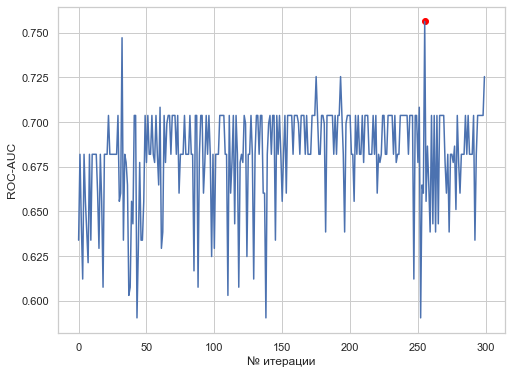

In [141]:
plt.figure(figsize=(8, 6))
plt.plot(scores3)
plt.scatter(scores3.index(study1_new.best_value), study1_new.best_value, color='red')
plt.xlabel('№ итерации')
plt.ylabel('ROC-AUC')
plt.plot();

Сохраним параметры модели и взглянем на метрики ещё раз.

In [143]:
np.random.seed(SEED)

model_params1_new = study1_new.best_params
model1_new = LGBMClassifier(objective="binary", **model_params1_new)

model1_new.fit(x_train_new, y_train_new)
get_scores(y_valid_new, model1_new.predict(x_valid_new), metrics=metrics)

accuracy_score: 0.6428571428571429
roc_auc_score: 0.6556064073226544


Значение метрики "roc-auc" на тесте равна 0.65561.  
Доля верных ответов (accuracy) составила 64.28571%.

Посмотрим на важность признаков.

In [144]:
np.random.seed(SEED)

perm1_new = PermutationImportance(model1_new, random_state=SEED).fit(x_valid_new, y_valid_new)
eli5.show_weights(perm1_new, feature_names=list(x_valid_new))

Weight,Feature
0.1143 ± 0.1360,kfu_bef_03
0.0905 ± 0.1292,Sum
0.0333 ± 0.1069,ROA_ncl_bef_02
0.0238 ± 0.0602,non_current_assets_diff_bef_03_04
0.0095 ± 0.0883,cost_amount_diff_bef_03_04
-0.0524 ± 0.0632,accounts_payable_diff_frac_bef_03_04


Наиболее значимыми для модели оказались признаки "kfu_bef_03" (коэффициент финансовой устойчивости -3 года, относительно текущего) и "Sum".  
Слабо значимы признаки - "ROA_ncl_bef_02" (рентабельность внеоборотных активов -2 года, относительно текущего)и "non_current_assets_diff_bef_03_04" (абсолютное изменение внеоборотных активов -3 года к -4, относительнео текущего).
Можно считать незначимым признак "cost_amount_diff_bef_03_04" (абсолютное изменение себестоимости -3 года к -4 относительно текущего), т.к. его вес отличен от нуля аж в третьем знаке после запятой.  
Негативно влияет на модель признак "accounts_payable_diff_frac_bef_03_04" (относительное изменение уровня кредиторской задолженности -3 года, к -4). Перед дальнейшими экспериментами этот признак будет удалён.

Построрим график влияния каждого признака на предсказания факта ПДЗ.

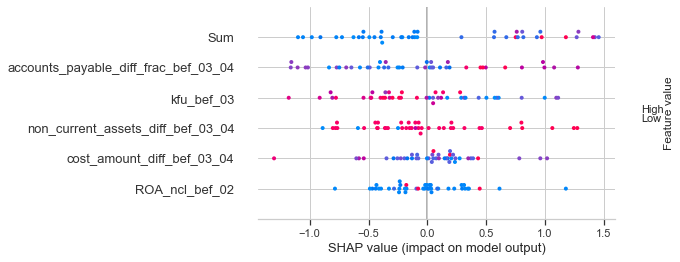

In [145]:
np.random.seed(SEED)

explainer1_new = shap.TreeExplainer(model1_new)
shap_values1_new = explainer1_new.shap_values(x_valid_new)
shap.summary_plot(shap_values1_new[1], x_valid_new)

Характер влияния на предсказания для новых контрагентов признаков "kfu_bef_03" (коэффициент финансовой устойчивости -3 года, относительно текущего) и "Sum" не изменился относительно их характера влияния на предсказания для старых контрагентов. Чем меньше "kfu_bef_03", тем более точнее получим предсказание. Аналогичное верное и для "Sum", но только в диаметрально противоположном направлении.

Признак "cost_amount_diff_bef_03_04" (абсолютное изменение себестоимости -3 года к -4) почти не влияет на предсказания модели, т.к. всё основное множество его значений расположено близ нулевой точки, а максимальная точка - это явный выброс, который сильно негативно влияет на предсказания модели.

Признак "accounts_payable_diff_frac_bef_03_04" (относительное изменение кредиторской задолженности -3 года к -4, относительно текузего) негативно влияет на предсказания модели, потому что почти все малые и средние его значения лежат по левую сторону от нулевой оси. Пара показателей с большим модулем (значением) не всенут заметного вклада из-за сильной скошенности в сторону небольших значений по этому параметру.

Дальнейшее обучение модели будет без признаков: "accounts_payable_diff_frac_bef_03_04" и "cost_amount_diff_bef_03_04".

In [147]:
cols_new = ['Sum', 'ROA_ncl_bef_02', 'kfu_bef_03', 'non_current_assets_diff_bef_03_04']

x_train_new4 = x_train_new.loc[:, cols_new]
x_valid_new4 = x_valid_new.loc[:, cols_new]

Определим все возможные комбинации признаков.

In [148]:
columns_combinations = list(combinations(list(x_train_new4), 2))
columns_combinations

[('Sum', 'ROA_ncl_bef_02'),
 ('Sum', 'kfu_bef_03'),
 ('Sum', 'non_current_assets_diff_bef_03_04'),
 ('ROA_ncl_bef_02', 'kfu_bef_03'),
 ('ROA_ncl_bef_02', 'non_current_assets_diff_bef_03_04'),
 ('kfu_bef_03', 'non_current_assets_diff_bef_03_04')]

Обучим столько моделей, сколько получилось пар признаков.

In [149]:
np.random.seed(SEED)

best_params = []
best_scores = []
for i in range(len(columns_combinations)):
    
    train = x_train_new4.loc[:, columns_combinations[i]]
    valid = x_valid_new4.loc[:, columns_combinations[i]]
    
    study2_new = optuna.create_study(direction="maximize", study_name="LGBM2_new")
    func2_new = lambda trial: optimize_hyperparams(trial, train, valid, y_train_new, y_valid_new)
    study2_new.optimize(func2_new, n_trials=300, show_progress_bar=True)
    
    best_scores.append(study2_new.best_value)
    best_params.append(study2_new.best_params)

[I 2022-03-19 18:39:01,686] A new study created in memory with name: LGBM2_new


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 0.649786
[I 2022-03-19 18:39:01,922] Trial 0 finished with value: 0.7334096109839817 and parameters: {'n_estimators': 700, 'learning_rate': 0.1626582116981855, 'num_leaves': 67, 'max_depth': 4, 'min_child_samples': 70, 'reg_alpha': 9.200000000000001, 'reg_lambda': 9.3}. Best is trial 0 with value: 0.7334096109839817.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[800]	valid_0's binary_logloss: 0.640785
[I 2022-03-19 18:39:02,217] Trial 1 finished with value: 0.7334096109839817 and parameters: {'n_estimators': 800, 'learning_rate': 0.07738975460538088, 'num_leaves': 26, 'max_depth': 4, 'min_child_samples': 185, 'reg_alpha': 5.4, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.7334096109839817.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[80]	v

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.631036
[I 2022-03-19 18:39:06,359] Trial 18 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 600, 'learning_rate': 0.10332230922105277, 'num_leaves': 43, 'max_depth': 7, 'min_child_samples': 38, 'reg_alpha': 2.4000000000000004, 'reg_lambda': 6.7}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[269]	valid_0's binary_logloss: 0.639619
[I 2022-03-19 18:39:06,666] Trial 19 finished with value: 0.6864988558352403 and parameters: {'n_estimators': 350, 'learning_rate': 0.04445035157663656, 'num_leaves': 98, 'max_depth': 4, 'min_child_samples': 89, 'reg_alpha': 4.1000000000000005, 'reg_lambda': 2.1}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.649039
[I 2022-

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.643329
[I 2022-03-19 18:39:10,679] Trial 36 finished with value: 0.7334096109839817 and parameters: {'n_estimators': 500, 'learning_rate': 0.15445598337834457, 'num_leaves': 92, 'max_depth': 7, 'min_child_samples': 77, 'reg_alpha': 7.300000000000001, 'reg_lambda': 8.5}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[746]	valid_0's binary_logloss: 0.648697
[I 2022-03-19 18:39:10,994] Trial 37 finished with value: 0.6338672768878719 and parameters: {'n_estimators': 750, 'learning_rate': 0.0542215364005932, 'num_leaves': 65, 'max_depth': 4, 'min_child_samples': 26, 'reg_alpha': 8.1, 'reg_lambda': 6.1000000000000005}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best ite

[I 2022-03-19 18:39:14,112] Trial 54 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 850, 'learning_rate': 0.2006593296871282, 'num_leaves': 10, 'max_depth': 7, 'min_child_samples': 80, 'reg_alpha': 5.4, 'reg_lambda': 4.0}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.639252
[I 2022-03-19 18:39:14,285] Trial 55 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 850, 'learning_rate': 0.18013003400465477, 'num_leaves': 10, 'max_depth': 7, 'min_child_samples': 94, 'reg_alpha': 3.8000000000000003, 'reg_lambda': 4.1000000000000005}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.64194
[I 2022-03-19 18:39:14,449] Trial 56 finished with value: 0.6819221967963386 and parameters: {'n_es

Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.648074
[I 2022-03-19 18:39:18,035] Trial 73 finished with value: 0.6464530892448512 and parameters: {'n_estimators': 750, 'learning_rate': 0.09325870081684057, 'num_leaves': 86, 'max_depth': 3, 'min_child_samples': 50, 'reg_alpha': 7.5, 'reg_lambda': 0.8}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.63694
[I 2022-03-19 18:39:18,199] Trial 74 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 850, 'learning_rate': 0.25043003090613036, 'num_leaves': 15, 'max_depth': 3, 'min_child_samples': 81, 'reg_alpha': 5.300000000000001, 'reg_lambda': 5.0}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[31]	valid_0's binary_logloss: 0.642
[I 2022-03-19 18:39:18,345] Trial 75 finis

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[177]	valid_0's binary_logloss: 0.638794
[I 2022-03-19 18:39:21,709] Trial 92 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 1000, 'learning_rate': 0.18762811190385384, 'num_leaves': 68, 'max_depth': 8, 'min_child_samples': 76, 'reg_alpha': 5.800000000000001, 'reg_lambda': 3.5}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[280]	valid_0's binary_logloss: 0.637386
[I 2022-03-19 18:39:21,988] Trial 93 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0656411759094601, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 67, 'reg_alpha': 5.7, 'reg_lambda': 0.1}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[337]	valid_0'

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.642077
[I 2022-03-19 18:39:25,547] Trial 110 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 950, 'learning_rate': 0.2007886112196267, 'num_leaves': 27, 'max_depth': 5, 'min_child_samples': 86, 'reg_alpha': 5.6000000000000005, 'reg_lambda': 3.9000000000000004}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.637274
[I 2022-03-19 18:39:25,710] Trial 111 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 900, 'learning_rate': 0.1961139495185864, 'num_leaves': 36, 'max_depth': 5, 'min_child_samples': 81, 'reg_alpha': 5.5, 'reg_lambda': 3.5}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.644942
[I 2022-0

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.641398
[I 2022-03-19 18:39:29,327] Trial 129 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 600, 'learning_rate': 0.26376673227538394, 'num_leaves': 139, 'max_depth': 4, 'min_child_samples': 72, 'reg_alpha': 6.6000000000000005, 'reg_lambda': 3.4000000000000004}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.640866
[I 2022-03-19 18:39:29,524] Trial 130 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 600, 'learning_rate': 0.27038094541251245, 'num_leaves': 151, 'max_depth': 3, 'min_child_samples': 90, 'reg_alpha': 5.300000000000001, 'reg_lambda': 7.4}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, be

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[117]	valid_0's binary_logloss: 0.636929
[I 2022-03-19 18:39:33,506] Trial 147 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 900, 'learning_rate': 0.19189059898803065, 'num_leaves': 30, 'max_depth': 5, 'min_child_samples': 74, 'reg_alpha': 5.2, 'reg_lambda': 4.3}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.641297
[I 2022-03-19 18:39:33,700] Trial 148 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 800, 'learning_rate': 0.20788293148214865, 'num_leaves': 153, 'max_depth': 5, 'min_child_samples': 74, 'reg_alpha': 6.6000000000000005, 'reg_lambda': 4.2}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[52]	valid_0

Did not meet early stopping. Best iteration is:
[800]	valid_0's binary_logloss: 0.645853
[I 2022-03-19 18:39:38,456] Trial 165 finished with value: 0.7334096109839817 and parameters: {'n_estimators': 800, 'learning_rate': 0.0324815591254735, 'num_leaves': 10, 'max_depth': 5, 'min_child_samples': 85, 'reg_alpha': 7.6000000000000005, 'reg_lambda': 3.6}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.637203
[I 2022-03-19 18:39:38,599] Trial 166 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 900, 'learning_rate': 0.1962522224295688, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 81, 'reg_alpha': 5.5, 'reg_lambda': 4.9}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.645274
[I 2022-03-19 18:39:38

Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.637448
[I 2022-03-19 18:39:42,169] Trial 183 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1767184517994113, 'num_leaves': 299, 'max_depth': 7, 'min_child_samples': 65, 'reg_alpha': 5.6000000000000005, 'reg_lambda': 6.5}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[387]	valid_0's binary_logloss: 0.637633
[I 2022-03-19 18:39:43,003] Trial 184 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 700, 'learning_rate': 0.06138736879908494, 'num_leaves': 238, 'max_depth': 10, 'min_child_samples': 69, 'reg_alpha': 5.800000000000001, 'reg_lambda': 0.0}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[434]	valid_0's binary_logloss: 0.637654
[I 2022-03-19 18:

Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.640216
[I 2022-03-19 18:39:47,296] Trial 201 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 700, 'learning_rate': 0.11155739734879835, 'num_leaves': 112, 'max_depth': 3, 'min_child_samples': 70, 'reg_alpha': 6.6000000000000005, 'reg_lambda': 2.6}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.631014
[I 2022-03-19 18:39:47,510] Trial 202 finished with value: 0.6430205949656751 and parameters: {'n_estimators': 950, 'learning_rate': 0.2614843542368092, 'num_leaves': 47, 'max_depth': 5, 'min_child_samples': 78, 'reg_alpha': 3.2, 'reg_lambda': 3.3000000000000003}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.641794
[I 2022-03-19 18:39:

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[291]	valid_0's binary_logloss: 0.635277
[I 2022-03-19 18:39:53,730] Trial 219 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 800, 'learning_rate': 0.1274162984612635, 'num_leaves': 144, 'max_depth': 6, 'min_child_samples': 67, 'reg_alpha': 4.9, 'reg_lambda': 4.4}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.635235
[I 2022-03-19 18:39:54,049] Trial 220 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 850, 'learning_rate': 0.06453775341110396, 'num_leaves': 141, 'max_depth': 6, 'min_child_samples': 76, 'reg_alpha': 4.6000000000000005, 'reg_lambda': 4.5}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[79]	valid_

Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.642371
[I 2022-03-19 18:39:58,234] Trial 237 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 650, 'learning_rate': 0.11051059563743965, 'num_leaves': 102, 'max_depth': 3, 'min_child_samples': 84, 'reg_alpha': 5.5, 'reg_lambda': 2.6}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.639217
[I 2022-03-19 18:39:58,381] Trial 238 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 700, 'learning_rate': 0.21907264965054038, 'num_leaves': 106, 'max_depth': 3, 'min_child_samples': 81, 'reg_alpha': 6.2, 'reg_lambda': 3.0}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[418]	valid_0's binary_logloss: 0.638722
[I 2022-03-19 18:39:58,750] Trial 239 finished w

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.63553
[I 2022-03-19 18:40:03,005] Trial 255 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 800, 'learning_rate': 0.1735568949285581, 'num_leaves': 279, 'max_depth': 5, 'min_child_samples': 73, 'reg_alpha': 5.1000000000000005, 'reg_lambda': 4.1000000000000005}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[285]	valid_0's binary_logloss: 0.641184
[I 2022-03-19 18:40:03,330] Trial 256 finished with value: 0.6990846681922197 and parameters: {'n_estimators': 900, 'learning_rate': 0.22489888181441112, 'num_leaves': 268, 'max_depth': 5, 'min_child_samples': 59, 'reg_alpha': 5.2, 'reg_lambda': 4.0}. Best is trial 12 with value: 0.7379862700228833.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.635873
[I 2022-03-19 18:40:

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.642401
[I 2022-03-19 18:40:07,796] Trial 273 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 850, 'learning_rate': 0.14911945644410773, 'num_leaves': 288, 'max_depth': 10, 'min_child_samples': 77, 'reg_alpha': 7.1000000000000005, 'reg_lambda': 0.6000000000000001}. Best is trial 264 with value: 0.7597254004576659.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.641489
[I 2022-03-19 18:40:08,105] Trial 274 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 850, 'learning_rate': 0.08249758110377078, 'num_leaves': 222, 'max_depth': 10, 'min_child_samples': 74, 'reg_alpha': 6.9, 'reg_lambda': 0.2}. Best is trial 264 with value: 0.7597254004576659.
Training until validation scores don't improve for 250 rounds
Early stopping, best itera

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.642146
[I 2022-03-19 18:40:13,196] Trial 291 finished with value: 0.6864988558352403 and parameters: {'n_estimators': 600, 'learning_rate': 0.12173691997710434, 'num_leaves': 260, 'max_depth': 7, 'min_child_samples': 88, 'reg_alpha': 6.6000000000000005, 'reg_lambda': 1.7000000000000002}. Best is trial 264 with value: 0.7597254004576659.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.636699
[I 2022-03-19 18:40:13,460] Trial 292 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 850, 'learning_rate': 0.2723752930467339, 'num_leaves': 94, 'max_depth': 8, 'min_child_samples': 81, 'reg_alpha': 5.2, 'reg_lambda': 4.6000000000000005}. Best is trial 264 with value: 0.7597254004576659.
Training until validation scores don't improve for 250 rounds
Early stopping, 

[I 2022-03-19 18:40:15,627] A new study created in memory with name: LGBM2_new


Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.63831
[I 2022-03-19 18:40:15,619] Trial 299 finished with value: 0.7379862700228833 and parameters: {'n_estimators': 700, 'learning_rate': 0.1078415473937203, 'num_leaves': 100, 'max_depth': 3, 'min_child_samples': 78, 'reg_alpha': 6.1000000000000005, 'reg_lambda': 2.4000000000000004}. Best is trial 264 with value: 0.7597254004576659.


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[600]	valid_0's binary_logloss: 0.648166
[I 2022-03-19 18:40:15,972] Trial 0 finished with value: 0.6556064073226544 and parameters: {'n_estimators': 600, 'learning_rate': 0.058258029282123716, 'num_leaves': 265, 'max_depth': 8, 'min_child_samples': 169, 'reg_alpha': 8.700000000000001, 'reg_lambda': 4.5}. Best is trial 0 with value: 0.6556064073226544.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.639481
[I 2022-03-19 18:40:16,234] Trial 1 finished with value: 0.6773455377574371 and parameters: {'n_estimators': 800, 'learning_rate': 0.03284630783831434, 'num_leaves': 108, 'max_depth': 5, 'min_child_samples': 11, 'reg_alpha': 8.5, 'reg_lambda': 1.6}. Best is trial 1 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[1

[I 2022-03-19 18:40:18,790] Trial 18 finished with value: 0.6556064073226544 and parameters: {'n_estimators': 200, 'learning_rate': 0.2636623809878391, 'num_leaves': 198, 'max_depth': 4, 'min_child_samples': 193, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.0}. Best is trial 17 with value: 0.7562929061784898.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's binary_logloss: 0.621686
[I 2022-03-19 18:40:19,212] Trial 19 finished with value: 0.7254004576659039 and parameters: {'n_estimators': 200, 'learning_rate': 0.12017292202678392, 'num_leaves': 295, 'max_depth': 5, 'min_child_samples': 78, 'reg_alpha': 1.8, 'reg_lambda': 1.4000000000000001}. Best is trial 17 with value: 0.7562929061784898.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_logloss: 0.637474
[I 2022-03-19 18:40:19,748] Trial 20 finished with value: 0.6556064073226544 and 

Did not meet early stopping. Best iteration is:
[71]	valid_0's binary_logloss: 0.635605
[I 2022-03-19 18:40:22,735] Trial 36 finished with value: 0.6556064073226544 and parameters: {'n_estimators': 150, 'learning_rate': 0.04113857497703835, 'num_leaves': 98, 'max_depth': 9, 'min_child_samples': 108, 'reg_alpha': 0.0, 'reg_lambda': 1.6}. Best is trial 23 with value: 0.7780320366132722.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.633511
[I 2022-03-19 18:40:22,867] Trial 37 finished with value: 0.6556064073226544 and parameters: {'n_estimators': 350, 'learning_rate': 0.14583193939363326, 'num_leaves': 208, 'max_depth': 10, 'min_child_samples': 134, 'reg_alpha': 0.8, 'reg_lambda': 0.8}. Best is trial 23 with value: 0.7780320366132722.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.617627
[I 2022-03-19 18:40:23,055] Trial 3

[I 2022-03-19 18:40:25,906] Trial 54 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 350, 'learning_rate': 0.20269588632348098, 'num_leaves': 201, 'max_depth': 6, 'min_child_samples': 27, 'reg_alpha': 0.5, 'reg_lambda': 2.1}. Best is trial 23 with value: 0.7780320366132722.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.598336
[I 2022-03-19 18:40:26,082] Trial 55 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 450, 'learning_rate': 0.19870559515474115, 'num_leaves': 207, 'max_depth': 6, 'min_child_samples': 45, 'reg_alpha': 0.5, 'reg_lambda': 2.2}. Best is trial 23 with value: 0.7780320366132722.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.596917
[I 2022-03-19 18:40:26,493] Trial 56 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 450, 'learning

[I 2022-03-19 18:40:29,252] Trial 73 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 100, 'learning_rate': 0.24085367276964725, 'num_leaves': 162, 'max_depth': 7, 'min_child_samples': 20, 'reg_alpha': 1.2000000000000002, 'reg_lambda': 4.2}. Best is trial 23 with value: 0.7780320366132722.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[138]	valid_0's binary_logloss: 0.583658
[I 2022-03-19 18:40:29,426] Trial 74 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 300, 'learning_rate': 0.23993247613932156, 'num_leaves': 148, 'max_depth': 7, 'min_child_samples': 22, 'reg_alpha': 1.1, 'reg_lambda': 4.2}. Best is trial 23 with value: 0.7780320366132722.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[112]	valid_0's binary_logloss: 0.636829
[I 2022-03-19 18:40:29,569] Trial 75 finished with value: 0.6556064073226544 and pa

Did not meet early stopping. Best iteration is:
[38]	valid_0's binary_logloss: 0.583812
[I 2022-03-19 18:40:33,320] Trial 91 finished with value: 0.7780320366132722 and parameters: {'n_estimators': 150, 'learning_rate': 0.23258560116340804, 'num_leaves': 142, 'max_depth': 10, 'min_child_samples': 8, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 0.8}. Best is trial 23 with value: 0.7780320366132722.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's binary_logloss: 0.594747
[I 2022-03-19 18:40:33,443] Trial 92 finished with value: 0.7780320366132722 and parameters: {'n_estimators': 150, 'learning_rate': 0.29019263832427505, 'num_leaves': 122, 'max_depth': 10, 'min_child_samples': 9, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 0.7000000000000001}. Best is trial 23 with value: 0.7780320366132722.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[31]	va

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[35]	valid_0's binary_logloss: 0.611257
[I 2022-03-19 18:40:36,165] Trial 109 finished with value: 0.7643020594965675 and parameters: {'n_estimators': 100, 'learning_rate': 0.22780050975752428, 'num_leaves': 65, 'max_depth': 10, 'min_child_samples': 7, 'reg_alpha': 2.7, 'reg_lambda': 1.7000000000000002}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's binary_logloss: 0.618346
[I 2022-03-19 18:40:36,301] Trial 110 finished with value: 0.7208237986270023 and parameters: {'n_estimators': 150, 'learning_rate': 0.2619833505103771, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 5, 'reg_alpha': 3.1, 'reg_lambda': 0.7000000000000001}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not m

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.600408
[I 2022-03-19 18:40:38,314] Trial 127 finished with value: 0.7780320366132722 and parameters: {'n_estimators': 100, 'learning_rate': 0.29280274890723995, 'num_leaves': 70, 'max_depth': 10, 'min_child_samples': 9, 'reg_alpha': 1.1, 'reg_lambda': 0.8}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[42]	valid_0's binary_logloss: 0.600533
[I 2022-03-19 18:40:38,432] Trial 128 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 150, 'learning_rate': 0.24510932226961835, 'num_leaves': 142, 'max_depth': 9, 'min_child_samples': 12, 'reg_alpha': 1.5, 'reg_lambda': 3.8000000000000003}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Early stopping, best i

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.631766
[I 2022-03-19 18:40:40,326] Trial 145 finished with value: 0.7208237986270023 and parameters: {'n_estimators': 200, 'learning_rate': 0.28224819950576935, 'num_leaves': 74, 'max_depth': 10, 'min_child_samples': 5, 'reg_alpha': 6.9, 'reg_lambda': 2.1}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[35]	valid_0's binary_logloss: 0.597135
[I 2022-03-19 18:40:40,436] Trial 146 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 100, 'learning_rate': 0.23768224366122395, 'num_leaves': 69, 'max_depth': 10, 'min_child_samples': 15, 'reg_alpha': 1.1, 'reg_lambda': 2.2}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best ite

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.607138
[I 2022-03-19 18:40:42,412] Trial 163 finished with value: 0.7517162471395882 and parameters: {'n_estimators': 150, 'learning_rate': 0.29726141187093674, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 15, 'reg_alpha': 2.7, 'reg_lambda': 1.6}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[59]	valid_0's binary_logloss: 0.606292
[I 2022-03-19 18:40:42,526] Trial 164 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 200, 'learning_rate': 0.284412447413788, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 24, 'reg_alpha': 2.4000000000000004, 'reg_lambda': 2.8000000000000003}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did no

Did not meet early stopping. Best iteration is:
[23]	valid_0's binary_logloss: 0.594187
[I 2022-03-19 18:40:44,474] Trial 181 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 150, 'learning_rate': 0.25751561242764487, 'num_leaves': 94, 'max_depth': 9, 'min_child_samples': 5, 'reg_alpha': 1.9000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's binary_logloss: 0.597912
[I 2022-03-19 18:40:44,589] Trial 182 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 150, 'learning_rate': 0.2587197166988055, 'num_leaves': 96, 'max_depth': 9, 'min_child_samples': 5, 'reg_alpha': 1.9000000000000001, 'reg_lambda': 0.30000000000000004}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iterati

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[24]	valid_0's binary_logloss: 0.602161
[I 2022-03-19 18:40:46,962] Trial 199 finished with value: 0.7780320366132722 and parameters: {'n_estimators': 150, 'learning_rate': 0.261167654484439, 'num_leaves': 97, 'max_depth': 9, 'min_child_samples': 9, 'reg_alpha': 2.0, 'reg_lambda': 0.4}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[16]	valid_0's binary_logloss: 0.608002
[I 2022-03-19 18:40:47,101] Trial 200 finished with value: 0.7562929061784898 and parameters: {'n_estimators': 100, 'learning_rate': 0.24786812785922133, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 14, 'reg_alpha': 1.6, 'reg_lambda': 0.5}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iterat

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's binary_logloss: 0.603503
[I 2022-03-19 18:40:52,769] Trial 235 finished with value: 0.8215102974828374 and parameters: {'n_estimators': 100, 'learning_rate': 0.24985711262096177, 'num_leaves': 103, 'max_depth': 9, 'min_child_samples': 8, 'reg_alpha': 1.9000000000000001, 'reg_lambda': 0.2}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's binary_logloss: 0.602189
[I 2022-03-19 18:40:53,040] Trial 236 finished with value: 0.7299771167048055 and parameters: {'n_estimators': 100, 'learning_rate': 0.24886113000855575, 'num_leaves': 103, 'max_depth': 9, 'min_child_samples': 18, 'reg_alpha': 2.5, 'reg_lambda': 0.2}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early sto

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's binary_logloss: 0.606616
[I 2022-03-19 18:40:56,142] Trial 253 finished with value: 0.7299771167048055 and parameters: {'n_estimators': 100, 'learning_rate': 0.2522889666440438, 'num_leaves': 113, 'max_depth': 9, 'min_child_samples': 12, 'reg_alpha': 2.5, 'reg_lambda': 0.6000000000000001}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.602283
[I 2022-03-19 18:40:56,386] Trial 254 finished with value: 0.7517162471395882 and parameters: {'n_estimators': 800, 'learning_rate': 0.2701267554981275, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 20, 'reg_alpha': 2.9000000000000004, 'reg_lambda': 0.0}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early st

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's binary_logloss: 0.606714
[I 2022-03-19 18:40:59,069] Trial 271 finished with value: 0.7299771167048055 and parameters: {'n_estimators': 250, 'learning_rate': 0.27016032985699157, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 17, 'reg_alpha': 3.0, 'reg_lambda': 0.5}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's binary_logloss: 0.613428
[I 2022-03-19 18:40:59,303] Trial 272 finished with value: 0.7780320366132722 and parameters: {'n_estimators': 250, 'learning_rate': 0.2869847638768999, 'num_leaves': 115, 'max_depth': 9, 'min_child_samples': 9, 'reg_alpha': 2.8000000000000003, 'reg_lambda': 0.8}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopp

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.600077
[I 2022-03-19 18:41:02,368] Trial 290 finished with value: 0.7299771167048055 and parameters: {'n_estimators': 200, 'learning_rate': 0.26329114617013416, 'num_leaves': 98, 'max_depth': 9, 'min_child_samples': 18, 'reg_alpha': 2.3000000000000003, 'reg_lambda': 0.0}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[28]	valid_0's binary_logloss: 0.604563
[I 2022-03-19 18:41:02,524] Trial 291 finished with value: 0.8215102974828374 and parameters: {'n_estimators': 150, 'learning_rate': 0.2311357703939564, 'num_leaves': 111, 'max_depth': 9, 'min_child_samples': 8, 'reg_alpha': 2.1, 'reg_lambda': 0.2}. Best is trial 93 with value: 0.8432494279176199.
Training until validation scores don't improve for 250 rounds
Did not meet early stopp

[I 2022-03-19 18:41:03,758] A new study created in memory with name: LGBM2_new


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.637546
[I 2022-03-19 18:41:03,929] Trial 0 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 350, 'learning_rate': 0.13428319892336826, 'num_leaves': 214, 'max_depth': 7, 'min_child_samples': 10, 'reg_alpha': 4.7, 'reg_lambda': 6.7}. Best is trial 0 with value: 0.7036613272311213.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's binary_logloss: 0.638718
[I 2022-03-19 18:41:03,980] Trial 1 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 250, 'learning_rate': 0.29508417947925625, 'num_leaves': 186, 'max_depth': 4, 'min_child_samples': 13, 'reg_alpha': 5.7, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.7036613272311213.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[799]	v

[I 2022-03-19 18:41:05,838] Trial 18 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 1000, 'learning_rate': 0.25248750016055976, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 200, 'reg_alpha': 6.6000000000000005, 'reg_lambda': 1.9000000000000001}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[234]	valid_0's binary_logloss: 0.625896
[I 2022-03-19 18:41:05,974] Trial 19 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 550, 'learning_rate': 0.2274987171201973, 'num_leaves': 171, 'max_depth': 4, 'min_child_samples': 112, 'reg_alpha': 3.9000000000000004, 'reg_lambda': 5.9}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[266]	valid_0's binary_logloss: 0.617886
[I 2022-03-19 18:41:06,109] Trial 20 finished with value: 0.7082379862700229 an

[I 2022-03-19 18:41:08,431] Trial 36 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 350, 'learning_rate': 0.1431393063065662, 'num_leaves': 278, 'max_depth': 3, 'min_child_samples': 17, 'reg_alpha': 3.2, 'reg_lambda': 8.0}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.620534
[I 2022-03-19 18:41:08,533] Trial 37 finished with value: 0.7254004576659039 and parameters: {'n_estimators': 800, 'learning_rate': 0.2884775837427017, 'num_leaves': 211, 'max_depth': 5, 'min_child_samples': 36, 'reg_alpha': 4.5, 'reg_lambda': 3.3000000000000003}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.629161
[I 2022-03-19 18:41:08,688] Trial 38 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 400,

Did not meet early stopping. Best iteration is:
[51]	valid_0's binary_logloss: 0.623194
[I 2022-03-19 18:41:10,728] Trial 54 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 150, 'learning_rate': 0.16486015306720073, 'num_leaves': 264, 'max_depth': 4, 'min_child_samples': 95, 'reg_alpha': 4.2, 'reg_lambda': 5.4}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.606661
[I 2022-03-19 18:41:10,809] Trial 55 finished with value: 0.7734553775743707 and parameters: {'n_estimators': 100, 'learning_rate': 0.21089676318365916, 'num_leaves': 290, 'max_depth': 3, 'min_child_samples': 72, 'reg_alpha': 4.2, 'reg_lambda': 5.4}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.607531
[I 2022-03-19 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's binary_logloss: 0.603108
[I 2022-03-19 18:41:14,452] Trial 72 finished with value: 0.7734553775743707 and parameters: {'n_estimators': 100, 'learning_rate': 0.24835593327478123, 'num_leaves': 221, 'max_depth': 3, 'min_child_samples': 54, 'reg_alpha': 4.0, 'reg_lambda': 5.7}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[130]	valid_0's binary_logloss: 0.607841
[I 2022-03-19 18:41:14,631] Trial 73 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 150, 'learning_rate': 0.23445600486413493, 'num_leaves': 275, 'max_depth': 4, 'min_child_samples': 66, 'reg_alpha': 4.7, 'reg_lambda': 4.9}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[113

[I 2022-03-19 18:41:17,951] Trial 90 finished with value: 0.7471395881006865 and parameters: {'n_estimators': 900, 'learning_rate': 0.20361749883406735, 'num_leaves': 243, 'max_depth': 3, 'min_child_samples': 45, 'reg_alpha': 3.8000000000000003, 'reg_lambda': 4.1000000000000005}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.603872
[I 2022-03-19 18:41:18,110] Trial 91 finished with value: 0.7471395881006865 and parameters: {'n_estimators': 950, 'learning_rate': 0.193848868154475, 'num_leaves': 281, 'max_depth': 3, 'min_child_samples': 50, 'reg_alpha': 4.3, 'reg_lambda': 5.7}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's binary_logloss: 0.608748
[I 2022-03-19 18:41:18,261] Trial 92 finished with value: 0.7734553775743707 and parame

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[147]	valid_0's binary_logloss: 0.610269
[I 2022-03-19 18:41:22,194] Trial 108 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 300, 'learning_rate': 0.2418943991213369, 'num_leaves': 268, 'max_depth': 3, 'min_child_samples': 62, 'reg_alpha': 5.0, 'reg_lambda': 5.1000000000000005}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.607503
[I 2022-03-19 18:41:22,541] Trial 109 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 950, 'learning_rate': 0.17840294818883307, 'num_leaves': 226, 'max_depth': 3, 'min_child_samples': 61, 'reg_alpha': 4.5, 'reg_lambda': 4.6000000000000005}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early st

Did not meet early stopping. Best iteration is:
[88]	valid_0's binary_logloss: 0.615672
[I 2022-03-19 18:41:26,928] Trial 126 finished with value: 0.7471395881006865 and parameters: {'n_estimators': 250, 'learning_rate': 0.2698065895215311, 'num_leaves': 245, 'max_depth': 3, 'min_child_samples': 41, 'reg_alpha': 4.9, 'reg_lambda': 4.5}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's binary_logloss: 0.60158
[I 2022-03-19 18:41:27,173] Trial 127 finished with value: 0.7471395881006865 and parameters: {'n_estimators': 200, 'learning_rate': 0.20108506177584365, 'num_leaves': 262, 'max_depth': 3, 'min_child_samples': 46, 'reg_alpha': 3.9000000000000004, 'reg_lambda': 5.6000000000000005}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[155]	valid_0's binary_l

[I 2022-03-19 18:41:31,354] Trial 144 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 150, 'learning_rate': 0.2359453493398809, 'num_leaves': 282, 'max_depth': 3, 'min_child_samples': 56, 'reg_alpha': 4.800000000000001, 'reg_lambda': 4.7}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's binary_logloss: 0.618611
[I 2022-03-19 18:41:31,524] Trial 145 finished with value: 0.7299771167048055 and parameters: {'n_estimators': 150, 'learning_rate': 0.1097623666472109, 'num_leaves': 280, 'max_depth': 3, 'min_child_samples': 57, 'reg_alpha': 6.0, 'reg_lambda': 4.2}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[197]	valid_0's binary_logloss: 0.600694
[I 2022-03-19 18:41:31,921] Trial 146 finished with value: 0.7734553775743707 and param

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.608968
[I 2022-03-19 18:41:36,372] Trial 162 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 950, 'learning_rate': 0.225658368004617, 'num_leaves': 286, 'max_depth': 4, 'min_child_samples': 65, 'reg_alpha': 4.6000000000000005, 'reg_lambda': 8.6}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.604385
[I 2022-03-19 18:41:36,582] Trial 163 finished with value: 0.7734553775743707 and parameters: {'n_estimators': 750, 'learning_rate': 0.20801820288836567, 'num_leaves': 285, 'max_depth': 3, 'min_child_samples': 75, 'reg_alpha': 4.0, 'reg_lambda': 4.9}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[143]	valid_0'

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[159]	valid_0's binary_logloss: 0.604066
[I 2022-03-19 18:41:39,915] Trial 181 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 200, 'learning_rate': 0.23360465631730093, 'num_leaves': 246, 'max_depth': 3, 'min_child_samples': 58, 'reg_alpha': 4.1000000000000005, 'reg_lambda': 4.2}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.605178
[I 2022-03-19 18:41:40,306] Trial 182 finished with value: 0.7517162471395882 and parameters: {'n_estimators': 900, 'learning_rate': 0.22652890490322256, 'num_leaves': 289, 'max_depth': 4, 'min_child_samples': 64, 'reg_alpha': 4.2, 'reg_lambda': 4.4}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.606935
[I 2022-03-19 18:41:44,509] Trial 199 finished with value: 0.7471395881006865 and parameters: {'n_estimators': 200, 'learning_rate': 0.25011043176330544, 'num_leaves': 245, 'max_depth': 3, 'min_child_samples': 48, 'reg_alpha': 4.800000000000001, 'reg_lambda': 4.2}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[119]	valid_0's binary_logloss: 0.614808
[I 2022-03-19 18:41:44,774] Trial 200 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 200, 'learning_rate': 0.24547863881262388, 'num_leaves': 116, 'max_depth': 3, 'min_child_samples': 59, 'reg_alpha': 5.1000000000000005, 'reg_lambda': 4.6000000000000005}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[177]	valid_0's binary_logloss: 0.611562
[I 2022-03-19 18:41:49,874] Trial 217 finished with value: 0.7299771167048055 and parameters: {'n_estimators': 350, 'learning_rate': 0.126969377649426, 'num_leaves': 280, 'max_depth': 3, 'min_child_samples': 71, 'reg_alpha': 4.800000000000001, 'reg_lambda': 7.7}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's binary_logloss: 0.603687
[I 2022-03-19 18:41:50,283] Trial 218 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 150, 'learning_rate': 0.11400139605931936, 'num_leaves': 165, 'max_depth': 3, 'min_child_samples': 68, 'reg_alpha': 3.9000000000000004, 'reg_lambda': 5.5}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early sto

[I 2022-03-19 18:41:55,717] Trial 235 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 100, 'learning_rate': 0.23405078720067474, 'num_leaves': 247, 'max_depth': 3, 'min_child_samples': 54, 'reg_alpha': 4.3, 'reg_lambda': 3.8000000000000003}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[198]	valid_0's binary_logloss: 0.604514
[I 2022-03-19 18:41:55,903] Trial 236 finished with value: 0.7734553775743707 and parameters: {'n_estimators': 200, 'learning_rate': 0.0867067486411551, 'num_leaves': 244, 'max_depth': 4, 'min_child_samples': 67, 'reg_alpha': 4.0, 'reg_lambda': 4.2}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.609205
[I 2022-03-19 18:41:56,072] Trial 237 finished with value: 0.7951945080091534 and parameters: {'n

[I 2022-03-19 18:41:58,772] Trial 253 finished with value: 0.7254004576659039 and parameters: {'n_estimators': 100, 'learning_rate': 0.2165826195358029, 'num_leaves': 116, 'max_depth': 6, 'min_child_samples': 68, 'reg_alpha': 4.1000000000000005, 'reg_lambda': 9.9}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.613587
[I 2022-03-19 18:41:58,957] Trial 254 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 250, 'learning_rate': 0.1912511755768265, 'num_leaves': 234, 'max_depth': 7, 'min_child_samples': 60, 'reg_alpha': 5.300000000000001, 'reg_lambda': 9.1}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[183]	valid_0's binary_logloss: 0.606885
[I 2022-03-19 18:41:59,129] Trial 255 finished with value: 0.77345537757

Did not meet early stopping. Best iteration is:
[181]	valid_0's binary_logloss: 0.603246
[I 2022-03-19 18:42:02,433] Trial 271 finished with value: 0.7517162471395882 and parameters: {'n_estimators': 200, 'learning_rate': 0.24917965769920394, 'num_leaves': 249, 'max_depth': 4, 'min_child_samples': 63, 'reg_alpha': 3.9000000000000004, 'reg_lambda': 5.0}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.606337
[I 2022-03-19 18:42:02,643] Trial 272 finished with value: 0.7734553775743707 and parameters: {'n_estimators': 100, 'learning_rate': 0.21230113671485124, 'num_leaves': 190, 'max_depth': 6, 'min_child_samples': 63, 'reg_alpha': 4.2, 'reg_lambda': 9.4}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's binary_logloss: 0.61

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[76]	valid_0's binary_logloss: 0.62891
[I 2022-03-19 18:42:07,041] Trial 289 finished with value: 0.7036613272311213 and parameters: {'n_estimators': 150, 'learning_rate': 0.23868695829928888, 'num_leaves': 279, 'max_depth': 4, 'min_child_samples': 6, 'reg_alpha': 4.3, 'reg_lambda': 4.7}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.61089
[I 2022-03-19 18:42:07,280] Trial 290 finished with value: 0.7471395881006865 and parameters: {'n_estimators': 850, 'learning_rate': 0.23487743381217296, 'num_leaves': 51, 'max_depth': 4, 'min_child_samples': 51, 'reg_alpha': 4.800000000000001, 'reg_lambda': 2.1}. Best is trial 7 with value: 0.7951945080091534.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[59]	v

[I 2022-03-19 18:42:10,048] A new study created in memory with name: LGBM2_new


Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[115]	valid_0's binary_logloss: 0.609182
[I 2022-03-19 18:42:10,035] Trial 299 finished with value: 0.7951945080091534 and parameters: {'n_estimators': 200, 'learning_rate': 0.24821820803945585, 'num_leaves': 248, 'max_depth': 5, 'min_child_samples': 67, 'reg_alpha': 4.5, 'reg_lambda': 5.6000000000000005}. Best is trial 7 with value: 0.7951945080091534.


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.708375
[I 2022-03-19 18:42:10,280] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 900, 'learning_rate': 0.09995591807474993, 'num_leaves': 117, 'max_depth': 8, 'min_child_samples': 76, 'reg_alpha': 7.9, 'reg_lambda': 6.800000000000001}. Best is trial 0 with value: 0.5.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[135]	valid_0's binary_logloss: 0.701544
[I 2022-03-19 18:42:10,441] Trial 1 finished with value: 0.625858123569794 and parameters: {'n_estimators': 350, 'learning_rate': 0.21387292986780307, 'num_leaves': 163, 'max_depth': 7, 'min_child_samples': 122, 'reg_alpha': 4.6000000000000005, 'reg_lambda': 8.1}. Best is trial 1 with value: 0.625858123569794.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[23]	valid_0's binary

Did not meet early stopping. Best iteration is:
[699]	valid_0's binary_logloss: 0.704343
[I 2022-03-19 18:42:14,100] Trial 18 finished with value: 0.5869565217391304 and parameters: {'n_estimators': 700, 'learning_rate': 0.003891237917479265, 'num_leaves': 263, 'max_depth': 3, 'min_child_samples': 52, 'reg_alpha': 6.1000000000000005, 'reg_lambda': 2.8000000000000003}. Best is trial 14 with value: 0.6739130434782609.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[110]	valid_0's binary_logloss: 0.697002
[I 2022-03-19 18:42:14,320] Trial 19 finished with value: 0.5469107551487414 and parameters: {'n_estimators': 150, 'learning_rate': 0.0733860570773513, 'num_leaves': 192, 'max_depth': 4, 'min_child_samples': 24, 'reg_alpha': 3.5, 'reg_lambda': 2.7}. Best is trial 14 with value: 0.6739130434782609.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[447]	valid_0's bina

[176]	valid_0's binary_logloss: 0.696266
[I 2022-03-19 18:42:19,187] Trial 36 finished with value: 0.625858123569794 and parameters: {'n_estimators': 850, 'learning_rate': 0.09130084545160233, 'num_leaves': 259, 'max_depth': 6, 'min_child_samples': 110, 'reg_alpha': 2.8000000000000003, 'reg_lambda': 4.0}. Best is trial 14 with value: 0.6739130434782609.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's binary_logloss: 0.699178
[I 2022-03-19 18:42:19,412] Trial 37 finished with value: 0.6475972540045767 and parameters: {'n_estimators': 250, 'learning_rate': 0.05184152104343573, 'num_leaves': 167, 'max_depth': 3, 'min_child_samples': 17, 'reg_alpha': 0.5, 'reg_lambda': 9.8}. Best is trial 14 with value: 0.6739130434782609.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[176]	valid_0's binary_logloss: 0.681599
[I 2022-03-19 18:42:19,785] Trial 38 finish

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[21]	valid_0's binary_logloss: 0.693314
[I 2022-03-19 18:42:24,262] Trial 55 finished with value: 0.625858123569794 and parameters: {'n_estimators': 150, 'learning_rate': 0.2802368963880241, 'num_leaves': 162, 'max_depth': 6, 'min_child_samples': 105, 'reg_alpha': 3.3000000000000003, 'reg_lambda': 7.5}. Best is trial 14 with value: 0.6739130434782609.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.691062
[I 2022-03-19 18:42:24,496] Trial 56 finished with value: 0.551487414187643 and parameters: {'n_estimators': 400, 'learning_rate': 0.10400953771718606, 'num_leaves': 201, 'max_depth': 5, 'min_child_samples': 30, 'reg_alpha': 2.5, 'reg_lambda': 6.2}. Best is trial 14 with value: 0.6739130434782609.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[34

Did not meet early stopping. Best iteration is:
[301]	valid_0's binary_logloss: 0.628777
[I 2022-03-19 18:42:33,119] Trial 90 finished with value: 0.6338672768878719 and parameters: {'n_estimators': 350, 'learning_rate': 0.21518068426570952, 'num_leaves': 161, 'max_depth': 7, 'min_child_samples': 14, 'reg_alpha': 0.8, 'reg_lambda': 5.300000000000001}. Best is trial 14 with value: 0.6739130434782609.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's binary_logloss: 0.675122
[I 2022-03-19 18:42:33,540] Trial 91 finished with value: 0.7173913043478262 and parameters: {'n_estimators': 150, 'learning_rate': 0.010497662895235325, 'num_leaves': 124, 'max_depth': 7, 'min_child_samples': 5, 'reg_alpha': 0.5, 'reg_lambda': 9.200000000000001}. Best is trial 91 with value: 0.7173913043478262.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[136]	valid_0's binary

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's binary_logloss: 0.68698
[I 2022-03-19 18:42:37,198] Trial 109 finished with value: 0.5732265446224256 and parameters: {'n_estimators': 150, 'learning_rate': 0.06641812127621566, 'num_leaves': 220, 'max_depth': 4, 'min_child_samples': 28, 'reg_alpha': 1.5, 'reg_lambda': 0.30000000000000004}. Best is trial 91 with value: 0.7173913043478262.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's binary_logloss: 0.68881
[I 2022-03-19 18:42:37,349] Trial 110 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 100, 'learning_rate': 0.09471270792041432, 'num_leaves': 273, 'max_depth': 4, 'min_child_samples': 21, 'reg_alpha': 1.6, 'reg_lambda': 6.300000000000001}. Best is trial 91 with value: 0.7173913043478262.
Training until validation scores don't improve for 250 rounds
Did not 

Did not meet early stopping. Best iteration is:
[114]	valid_0's binary_logloss: 0.6703
[I 2022-03-19 18:42:40,614] Trial 127 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 150, 'learning_rate': 0.16270929094932354, 'num_leaves': 256, 'max_depth': 4, 'min_child_samples': 20, 'reg_alpha': 0.2, 'reg_lambda': 2.5}. Best is trial 91 with value: 0.7173913043478262.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[43]	valid_0's binary_logloss: 0.664142
[I 2022-03-19 18:42:40,810] Trial 128 finished with value: 0.6121281464530892 and parameters: {'n_estimators': 100, 'learning_rate': 0.12562382429395533, 'num_leaves': 243, 'max_depth': 4, 'min_child_samples': 10, 'reg_alpha': 0.5, 'reg_lambda': 1.1}. Best is trial 91 with value: 0.7173913043478262.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's binary_logloss: 0.700346
[I 2022-03-

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[25]	valid_0's binary_logloss: 0.678775
[I 2022-03-19 18:42:45,556] Trial 145 finished with value: 0.6304347826086957 and parameters: {'n_estimators': 150, 'learning_rate': 0.11443486728363665, 'num_leaves': 242, 'max_depth': 4, 'min_child_samples': 16, 'reg_alpha': 2.0, 'reg_lambda': 0.6000000000000001}. Best is trial 91 with value: 0.7173913043478262.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.681176
[I 2022-03-19 18:42:45,883] Trial 146 finished with value: 0.6212814645308924 and parameters: {'n_estimators': 150, 'learning_rate': 0.12867227187681118, 'num_leaves': 276, 'max_depth': 5, 'min_child_samples': 25, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 0.7000000000000001}. Best is trial 91 with value: 0.7173913043478262.
Training until validation scores don't improve for 25

[I 2022-03-19 18:42:50,169] Trial 163 finished with value: 0.7173913043478262 and parameters: {'n_estimators': 100, 'learning_rate': 0.09231937746474211, 'num_leaves': 247, 'max_depth': 4, 'min_child_samples': 15, 'reg_alpha': 1.1, 'reg_lambda': 1.4000000000000001}. Best is trial 91 with value: 0.7173913043478262.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[33]	valid_0's binary_logloss: 0.677329
[I 2022-03-19 18:42:50,412] Trial 164 finished with value: 0.7173913043478262 and parameters: {'n_estimators': 200, 'learning_rate': 0.07544138637481297, 'num_leaves': 242, 'max_depth': 4, 'min_child_samples': 16, 'reg_alpha': 1.1, 'reg_lambda': 1.2000000000000002}. Best is trial 91 with value: 0.7173913043478262.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[26]	valid_0's binary_logloss: 0.679718
[I 2022-03-19 18:42:50,745] Trial 165 finished with value: 0.6521739

Did not meet early stopping. Best iteration is:
[8]	valid_0's binary_logloss: 0.695045
[I 2022-03-19 18:42:55,507] Trial 181 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 100, 'learning_rate': 0.09971707377200797, 'num_leaves': 262, 'max_depth': 4, 'min_child_samples': 9, 'reg_alpha': 1.4000000000000001, 'reg_lambda': 0.2}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.682131
[I 2022-03-19 18:42:55,708] Trial 182 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 100, 'learning_rate': 0.07918031236508029, 'num_leaves': 253, 'max_depth': 4, 'min_child_samples': 16, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.4}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's binar

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.683648
[I 2022-03-19 18:42:59,599] Trial 199 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 100, 'learning_rate': 0.16347595837394893, 'num_leaves': 258, 'max_depth': 4, 'min_child_samples': 22, 'reg_alpha': 0.9, 'reg_lambda': 1.6}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's binary_logloss: 0.674896
[I 2022-03-19 18:42:59,951] Trial 200 finished with value: 0.6167048054919908 and parameters: {'n_estimators': 100, 'learning_rate': 0.17198406472924976, 'num_leaves': 273, 'max_depth': 4, 'min_child_samples': 81, 'reg_alpha': 0.2, 'reg_lambda': 1.1}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best 

[I 2022-03-19 18:43:04,834] Trial 216 finished with value: 0.6086956521739131 and parameters: {'n_estimators': 150, 'learning_rate': 0.12619935146550196, 'num_leaves': 242, 'max_depth': 4, 'min_child_samples': 8, 'reg_alpha': 1.2000000000000002, 'reg_lambda': 2.2}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's binary_logloss: 0.670275
[I 2022-03-19 18:43:05,157] Trial 217 finished with value: 0.6739130434782609 and parameters: {'n_estimators': 150, 'learning_rate': 0.1350200921524062, 'num_leaves': 260, 'max_depth': 4, 'min_child_samples': 11, 'reg_alpha': 1.0, 'reg_lambda': 1.8}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's binary_logloss: 0.683782
[I 2022-03-19 18:43:05,397] Trial 218 finished with value: 0.6384439359267735 and 

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[12]	valid_0's binary_logloss: 0.67873
[I 2022-03-19 18:43:09,066] Trial 234 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 100, 'learning_rate': 0.18538938651492884, 'num_leaves': 282, 'max_depth': 4, 'min_child_samples': 17, 'reg_alpha': 0.8, 'reg_lambda': 1.5}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's binary_logloss: 0.681748
[I 2022-03-19 18:43:09,325] Trial 235 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 100, 'learning_rate': 0.18561636327782566, 'num_leaves': 294, 'max_depth': 4, 'min_child_samples': 24, 'reg_alpha': 0.9, 'reg_lambda': 1.4000000000000001}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early s

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's binary_logloss: 0.70348
[I 2022-03-19 18:43:14,450] Trial 252 finished with value: 0.5 and parameters: {'n_estimators': 150, 'learning_rate': 0.15354825456118754, 'num_leaves': 267, 'max_depth': 4, 'min_child_samples': 70, 'reg_alpha': 6.7, 'reg_lambda': 1.0}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[19]	valid_0's binary_logloss: 0.678702
[I 2022-03-19 18:43:14,771] Trial 253 finished with value: 0.6739130434782609 and parameters: {'n_estimators': 100, 'learning_rate': 0.09410528795961273, 'num_leaves': 273, 'max_depth': 4, 'min_child_samples': 14, 'reg_alpha': 0.5, 'reg_lambda': 0.7000000000000001}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best i

Did not meet early stopping. Best iteration is:
[75]	valid_0's binary_logloss: 0.66032
[I 2022-03-19 18:43:19,259] Trial 270 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 100, 'learning_rate': 0.18549360746515167, 'num_leaves': 293, 'max_depth': 4, 'min_child_samples': 19, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 0.8}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[14]	valid_0's binary_logloss: 0.671006
[I 2022-03-19 18:43:19,487] Trial 271 finished with value: 0.6910755148741419 and parameters: {'n_estimators': 150, 'learning_rate': 0.1630223847472203, 'num_leaves': 271, 'max_depth': 4, 'min_child_samples': 14, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 1.2000000000000002}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[14]

Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.677267
[I 2022-03-19 18:43:23,842] Trial 288 finished with value: 0.6956521739130435 and parameters: {'n_estimators': 600, 'learning_rate': 0.07520552479275751, 'num_leaves': 274, 'max_depth': 4, 'min_child_samples': 15, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.6000000000000001}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[148]	valid_0's binary_logloss: 0.670033
[I 2022-03-19 18:43:24,087] Trial 289 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 150, 'learning_rate': 0.17574524374481354, 'num_leaves': 278, 'max_depth': 4, 'min_child_samples': 20, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 1.0}. Best is trial 175 with value: 0.7391304347826086.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's

[I 2022-03-19 18:43:27,282] A new study created in memory with name: LGBM2_new


[I 2022-03-19 18:43:27,263] Trial 299 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 250, 'learning_rate': 0.11089518616594177, 'num_leaves': 288, 'max_depth': 4, 'min_child_samples': 20, 'reg_alpha': 1.2000000000000002, 'reg_lambda': 0.4}. Best is trial 175 with value: 0.7391304347826086.


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.703447
[I 2022-03-19 18:43:27,623] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 200, 'learning_rate': 0.006504789367076537, 'num_leaves': 69, 'max_depth': 6, 'min_child_samples': 55, 'reg_alpha': 8.9, 'reg_lambda': 5.0}. Best is trial 0 with value: 0.5.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.69437
[I 2022-03-19 18:43:27,831] Trial 1 finished with value: 0.5389016018306636 and parameters: {'n_estimators': 450, 'learning_rate': 0.11517347103996986, 'num_leaves': 236, 'max_depth': 8, 'min_child_samples': 82, 'reg_alpha': 3.0, 'reg_lambda': 2.4000000000000004}. Best is trial 1 with value: 0.5389016018306636.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.6

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.688077
[I 2022-03-19 18:43:33,526] Trial 18 finished with value: 0.5 and parameters: {'n_estimators': 800, 'learning_rate': 0.1836434786075333, 'num_leaves': 201, 'max_depth': 5, 'min_child_samples': 166, 'reg_alpha': 4.0, 'reg_lambda': 4.9}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.68835
[I 2022-03-19 18:43:33,811] Trial 19 finished with value: 0.5 and parameters: {'n_estimators': 1000, 'learning_rate': 0.23131096393758474, 'num_leaves': 102, 'max_depth': 7, 'min_child_samples': 146, 'reg_alpha': 0.0, 'reg_lambda': 7.0}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.686074
[I 2022-03-19 18:4

Did not meet early stopping. Best iteration is:
[949]	valid_0's binary_logloss: 0.68034
[I 2022-03-19 18:43:39,877] Trial 36 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 950, 'learning_rate': 0.16240764931493717, 'num_leaves': 190, 'max_depth': 3, 'min_child_samples': 180, 'reg_alpha': 1.5, 'reg_lambda': 7.6000000000000005}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[950]	valid_0's binary_logloss: 0.662134
[I 2022-03-19 18:43:40,546] Trial 37 finished with value: 0.6121281464530892 and parameters: {'n_estimators': 950, 'learning_rate': 0.12290994349047774, 'num_leaves': 184, 'max_depth': 9, 'min_child_samples': 179, 'reg_alpha': 0.0, 'reg_lambda': 7.800000000000001}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[483]	valid_0's bina

Did not meet early stopping. Best iteration is:
[300]	valid_0's binary_logloss: 0.68227
[I 2022-03-19 18:43:46,147] Trial 54 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 300, 'learning_rate': 0.060729051452036845, 'num_leaves': 37, 'max_depth': 10, 'min_child_samples': 200, 'reg_alpha': 1.8, 'reg_lambda': 0.6000000000000001}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[250]	valid_0's binary_logloss: 0.680157
[I 2022-03-19 18:43:46,648] Trial 55 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 250, 'learning_rate': 0.10390332984732023, 'num_leaves': 35, 'max_depth': 10, 'min_child_samples': 188, 'reg_alpha': 0.4, 'reg_lambda': 7.5}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[179]	valid_0's binary_logloss: 0

Did not meet early stopping. Best iteration is:
[150]	valid_0's binary_logloss: 0.680948
[I 2022-03-19 18:43:52,912] Trial 72 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 150, 'learning_rate': 0.13355160506896324, 'num_leaves': 56, 'max_depth': 9, 'min_child_samples': 182, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 7.9}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[450]	valid_0's binary_logloss: 0.675315
[I 2022-03-19 18:43:53,297] Trial 73 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 450, 'learning_rate': 0.24871228259555678, 'num_leaves': 205, 'max_depth': 7, 'min_child_samples': 184, 'reg_alpha': 1.0, 'reg_lambda': 9.5}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.6

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_logloss: 0.689377
[I 2022-03-19 18:43:58,929] Trial 90 finished with value: 0.5 and parameters: {'n_estimators': 400, 'learning_rate': 0.14538082439636313, 'num_leaves': 148, 'max_depth': 8, 'min_child_samples': 160, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 8.700000000000001}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.682095
[I 2022-03-19 18:43:59,156] Trial 91 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 100, 'learning_rate': 0.1306578136802024, 'num_leaves': 66, 'max_depth': 9, 'min_child_samples': 185, 'reg_alpha': 1.0, 'reg_lambda': 9.700000000000001}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early sto

Did not meet early stopping. Best iteration is:
[249]	valid_0's binary_logloss: 0.677034
[I 2022-03-19 18:44:06,214] Trial 108 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 250, 'learning_rate': 0.21412318538378483, 'num_leaves': 44, 'max_depth': 10, 'min_child_samples': 189, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 6.800000000000001}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[298]	valid_0's binary_logloss: 0.680104
[I 2022-03-19 18:44:06,520] Trial 109 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 300, 'learning_rate': 0.0546662362876155, 'num_leaves': 54, 'max_depth': 10, 'min_child_samples': 191, 'reg_alpha': 0.2, 'reg_lambda': 7.300000000000001}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[83]

Did not meet early stopping. Best iteration is:
[748]	valid_0's binary_logloss: 0.658106
[I 2022-03-19 18:44:11,901] Trial 126 finished with value: 0.6338672768878719 and parameters: {'n_estimators': 750, 'learning_rate': 0.12291669122502863, 'num_leaves': 242, 'max_depth': 6, 'min_child_samples': 174, 'reg_alpha': 0.0, 'reg_lambda': 2.9000000000000004}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[649]	valid_0's binary_logloss: 0.679421
[I 2022-03-19 18:44:12,161] Trial 127 finished with value: 0.5640732265446224 and parameters: {'n_estimators': 650, 'learning_rate': 0.2613694916324862, 'num_leaves': 134, 'max_depth': 6, 'min_child_samples': 154, 'reg_alpha': 0.2, 'reg_lambda': 3.4000000000000004}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[797]	valid_0's b

Did not meet early stopping. Best iteration is:
[783]	valid_0's binary_logloss: 0.648
[I 2022-03-19 18:44:17,619] Trial 144 finished with value: 0.6773455377574371 and parameters: {'n_estimators': 800, 'learning_rate': 0.29006683235013714, 'num_leaves': 123, 'max_depth': 5, 'min_child_samples': 175, 'reg_alpha': 0.2, 'reg_lambda': 6.5}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[799]	valid_0's binary_logloss: 0.672717
[I 2022-03-19 18:44:17,871] Trial 145 finished with value: 0.6773455377574371 and parameters: {'n_estimators': 800, 'learning_rate': 0.2894219133867481, 'num_leaves': 122, 'max_depth': 5, 'min_child_samples': 170, 'reg_alpha': 0.2, 'reg_lambda': 3.1}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[787]	valid_0's binary_logloss: 0.673559
[I 2022-0

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[896]	valid_0's binary_logloss: 0.651352
[I 2022-03-19 18:44:23,827] Trial 162 finished with value: 0.6556064073226544 and parameters: {'n_estimators': 900, 'learning_rate': 0.27561729126438744, 'num_leaves': 132, 'max_depth': 5, 'min_child_samples': 175, 'reg_alpha': 0.5, 'reg_lambda': 3.9000000000000004}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[799]	valid_0's binary_logloss: 0.651009
[I 2022-03-19 18:44:24,187] Trial 163 finished with value: 0.6773455377574371 and parameters: {'n_estimators': 800, 'learning_rate': 0.2656383425207196, 'num_leaves': 127, 'max_depth': 5, 'min_child_samples': 173, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 4.1000000000000005}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve fo

Did not meet early stopping. Best iteration is:
[738]	valid_0's binary_logloss: 0.645588
[I 2022-03-19 18:44:31,192] Trial 180 finished with value: 0.6773455377574371 and parameters: {'n_estimators': 750, 'learning_rate': 0.2988860734216663, 'num_leaves': 114, 'max_depth': 5, 'min_child_samples': 176, 'reg_alpha': 0.0, 'reg_lambda': 4.6000000000000005}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[799]	valid_0's binary_logloss: 0.647568
[I 2022-03-19 18:44:31,584] Trial 181 finished with value: 0.6773455377574371 and parameters: {'n_estimators': 800, 'learning_rate': 0.2998585469700345, 'num_leaves': 126, 'max_depth': 5, 'min_child_samples': 176, 'reg_alpha': 0.2, 'reg_lambda': 4.3}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[799]	valid_0's binary_logloss: 0

Did not meet early stopping. Best iteration is:
[799]	valid_0's binary_logloss: 0.646407
[I 2022-03-19 18:44:36,987] Trial 198 finished with value: 0.6773455377574371 and parameters: {'n_estimators': 800, 'learning_rate': 0.274496965702195, 'num_leaves': 97, 'max_depth': 5, 'min_child_samples': 173, 'reg_alpha': 0.0, 'reg_lambda': 4.0}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[584]	valid_0's binary_logloss: 0.677634
[I 2022-03-19 18:44:37,280] Trial 199 finished with value: 0.6075514874141876 and parameters: {'n_estimators': 800, 'learning_rate': 0.29330060163481275, 'num_leaves': 110, 'max_depth': 5, 'min_child_samples': 162, 'reg_alpha': 0.2, 'reg_lambda': 4.7}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[800]	valid_0's binary_logloss: 0.653028
[I 2022-

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[748]	valid_0's binary_logloss: 0.655043
[I 2022-03-19 18:44:43,089] Trial 216 finished with value: 0.6556064073226544 and parameters: {'n_estimators': 750, 'learning_rate': 0.25924966045891845, 'num_leaves': 96, 'max_depth': 5, 'min_child_samples': 183, 'reg_alpha': 0.0, 'reg_lambda': 5.300000000000001}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[577]	valid_0's binary_logloss: 0.67904
[I 2022-03-19 18:44:43,359] Trial 217 finished with value: 0.5640732265446224 and parameters: {'n_estimators': 750, 'learning_rate': 0.29097988507607697, 'num_leaves': 123, 'max_depth': 5, 'min_child_samples': 161, 'reg_alpha': 0.2, 'reg_lambda': 4.5}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early s

Did not meet early stopping. Best iteration is:
[835]	valid_0's binary_logloss: 0.649604
[I 2022-03-19 18:44:48,992] Trial 234 finished with value: 0.6773455377574371 and parameters: {'n_estimators': 850, 'learning_rate': 0.2760447648473035, 'num_leaves': 102, 'max_depth': 5, 'min_child_samples': 174, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 5.1000000000000005}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[745]	valid_0's binary_logloss: 0.651307
[I 2022-03-19 18:44:49,289] Trial 235 finished with value: 0.6556064073226544 and parameters: {'n_estimators': 750, 'learning_rate': 0.28116827520330906, 'num_leaves': 96, 'max_depth': 5, 'min_child_samples': 175, 'reg_alpha': 0.4, 'reg_lambda': 5.0}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[140]	valid_0's binary_logloss

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.690769
[I 2022-03-19 18:44:54,084] Trial 252 finished with value: 0.5 and parameters: {'n_estimators': 750, 'learning_rate': 0.24422198481767385, 'num_leaves': 109, 'max_depth': 5, 'min_child_samples': 117, 'reg_alpha': 3.2, 'reg_lambda': 4.4}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[503]	valid_0's binary_logloss: 0.679617
[I 2022-03-19 18:44:54,421] Trial 253 finished with value: 0.6075514874141876 and parameters: {'n_estimators': 850, 'learning_rate': 0.27772108355442093, 'num_leaves': 143, 'max_depth': 5, 'min_child_samples': 160, 'reg_alpha': 0.0, 'reg_lambda': 4.6000000000000005}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[699]	valid_0's binary_logloss: 0.657631
[I 2022-03-19 18:44:54,715] Tria

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[698]	valid_0's binary_logloss: 0.655514
[I 2022-03-19 18:44:59,235] Trial 270 finished with value: 0.6556064073226544 and parameters: {'n_estimators': 700, 'learning_rate': 0.2587922292148501, 'num_leaves': 146, 'max_depth': 5, 'min_child_samples': 182, 'reg_alpha': 0.0, 'reg_lambda': 4.5}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[750]	valid_0's binary_logloss: 0.674532
[I 2022-03-19 18:44:59,522] Trial 271 finished with value: 0.6338672768878719 and parameters: {'n_estimators': 750, 'learning_rate': 0.2688279949251373, 'num_leaves': 128, 'max_depth': 5, 'min_child_samples': 170, 'reg_alpha': 0.4, 'reg_lambda': 4.1000000000000005}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Early stopping, bes

Did not meet early stopping. Best iteration is:
[797]	valid_0's binary_logloss: 0.645952
[I 2022-03-19 18:45:06,586] Trial 288 finished with value: 0.6773455377574371 and parameters: {'n_estimators': 800, 'learning_rate': 0.2680820879657467, 'num_leaves': 121, 'max_depth': 5, 'min_child_samples': 176, 'reg_alpha': 0.0, 'reg_lambda': 3.8000000000000003}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[490]	valid_0's binary_logloss: 0.676719
[I 2022-03-19 18:45:06,870] Trial 289 finished with value: 0.5640732265446224 and parameters: {'n_estimators': 750, 'learning_rate': 0.2939118379614986, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 163, 'reg_alpha': 0.0, 'reg_lambda': 4.0}. Best is trial 14 with value: 0.6773455377574371.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.655124
[I 2022-03-19 18:45

[I 2022-03-19 18:45:09,916] A new study created in memory with name: LGBM2_new


Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[949]	valid_0's binary_logloss: 0.662918
[I 2022-03-19 18:45:09,909] Trial 299 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 950, 'learning_rate': 0.24890019926466508, 'num_leaves': 95, 'max_depth': 7, 'min_child_samples': 187, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 5.2}. Best is trial 298 with value: 0.6819221967963386.


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[150]	valid_0's binary_logloss: 0.683808
[I 2022-03-19 18:45:10,129] Trial 0 finished with value: 0.6338672768878719 and parameters: {'n_estimators': 150, 'learning_rate': 0.21653137533630423, 'num_leaves': 276, 'max_depth': 10, 'min_child_samples': 198, 'reg_alpha': 0.0, 'reg_lambda': 9.3}. Best is trial 0 with value: 0.6338672768878719.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.673386
[I 2022-03-19 18:45:10,235] Trial 1 finished with value: 0.6212814645308924 and parameters: {'n_estimators': 650, 'learning_rate': 0.13877649772200207, 'num_leaves': 131, 'max_depth': 5, 'min_child_samples': 51, 'reg_alpha': 6.6000000000000005, 'reg_lambda': 7.9}. Best is trial 0 with value: 0.6338672768878719.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[1

Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's binary_logloss: 0.651968
[I 2022-03-19 18:45:17,037] Trial 35 finished with value: 0.6601830663615561 and parameters: {'n_estimators': 100, 'learning_rate': 0.18530484847341577, 'num_leaves': 36, 'max_depth': 4, 'min_child_samples': 7, 'reg_alpha': 3.4000000000000004, 'reg_lambda': 9.700000000000001}. Best is trial 24 with value: 0.6819221967963386.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's binary_logloss: 0.652751
[I 2022-03-19 18:45:17,252] Trial 36 finished with value: 0.6647597254004577 and parameters: {'n_estimators': 100, 'learning_rate': 0.19148185090435627, 'num_leaves': 62, 'max_depth': 4, 'min_child_samples': 7, 'reg_alpha': 4.1000000000000005, 'reg_lambda': 10.0}. Best is trial 24 with value: 0.6819221967963386.
Training until validation scores don't improve for 250 roun

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.66189
[I 2022-03-19 18:45:20,951] Trial 53 finished with value: 0.6430205949656751 and parameters: {'n_estimators': 300, 'learning_rate': 0.16031739592789454, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 11, 'reg_alpha': 4.0, 'reg_lambda': 2.1}. Best is trial 52 with value: 0.6864988558352403.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_logloss: 0.658866
[I 2022-03-19 18:45:21,193] Trial 54 finished with value: 0.6601830663615561 and parameters: {'n_estimators': 450, 'learning_rate': 0.17370056991551994, 'num_leaves': 69, 'max_depth': 4, 'min_child_samples': 6, 'reg_alpha': 2.6, 'reg_lambda': 1.1}. Best is trial 52 with value: 0.6864988558352403.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.658088
[I 2022-03-19 18:45:24,986] Trial 72 finished with value: 0.6121281464530892 and parameters: {'n_estimators': 400, 'learning_rate': 0.2615957160240604, 'num_leaves': 60, 'max_depth': 5, 'min_child_samples': 35, 'reg_alpha': 3.7, 'reg_lambda': 4.9}. Best is trial 52 with value: 0.6864988558352403.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's binary_logloss: 0.67199
[I 2022-03-19 18:45:25,127] Trial 73 finished with value: 0.6121281464530892 and parameters: {'n_estimators': 100, 'learning_rate': 0.1857829425587818, 'num_leaves': 152, 'max_depth': 4, 'min_child_samples': 92, 'reg_alpha': 3.3000000000000003, 'reg_lambda': 5.5}. Best is trial 52 with value: 0.6864988558352403.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iterat

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_logloss: 0.675631
[I 2022-03-19 18:45:28,583] Trial 90 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 650, 'learning_rate': 0.08372994785398806, 'num_leaves': 65, 'max_depth': 7, 'min_child_samples': 10, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 3.9000000000000004}. Best is trial 84 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.6608
[I 2022-03-19 18:45:28,810] Trial 91 finished with value: 0.6864988558352403 and parameters: {'n_estimators': 700, 'learning_rate': 0.1655630007444378, 'num_leaves': 33, 'max_depth': 6, 'min_child_samples': 16, 'reg_alpha': 1.1, 'reg_lambda': 3.2}. Best is trial 84 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[11]

[I 2022-03-19 18:45:33,869] Trial 108 finished with value: 0.6647597254004577 and parameters: {'n_estimators': 850, 'learning_rate': 0.16212226413356856, 'num_leaves': 164, 'max_depth': 6, 'min_child_samples': 16, 'reg_alpha': 0.5, 'reg_lambda': 3.7}. Best is trial 84 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_logloss: 0.654333
[I 2022-03-19 18:45:34,122] Trial 109 finished with value: 0.6647597254004577 and parameters: {'n_estimators': 750, 'learning_rate': 0.12982199660317104, 'num_leaves': 202, 'max_depth': 6, 'min_child_samples': 9, 'reg_alpha': 1.9000000000000001, 'reg_lambda': 4.1000000000000005}. Best is trial 84 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[222]	valid_0's binary_logloss: 0.674329
[I 2022-03-19 18:45:34,440] Trial 110 finished with value: 0.6121281464530892 and parameters: 

[I 2022-03-19 18:45:38,281] Trial 126 finished with value: 0.6647597254004577 and parameters: {'n_estimators': 750, 'learning_rate': 0.04631271527289109, 'num_leaves': 122, 'max_depth': 6, 'min_child_samples': 14, 'reg_alpha': 1.3, 'reg_lambda': 1.9000000000000001}. Best is trial 84 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.680505
[I 2022-03-19 18:45:38,682] Trial 127 finished with value: 0.6475972540045767 and parameters: {'n_estimators': 800, 'learning_rate': 0.13984938622646031, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 20, 'reg_alpha': 0.1, 'reg_lambda': 0.8}. Best is trial 84 with value: 0.7128146453089245.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.675973
[I 2022-03-19 18:45:38,852] Trial 128 finished with value: 0.6693363844393592 and parameters: {'n_estimators': 

Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.673542
[I 2022-03-19 18:45:43,710] Trial 144 finished with value: 0.7299771167048055 and parameters: {'n_estimators': 600, 'learning_rate': 0.05422993986557442, 'num_leaves': 179, 'max_depth': 6, 'min_child_samples': 23, 'reg_alpha': 0.0, 'reg_lambda': 1.3}. Best is trial 144 with value: 0.7299771167048055.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[21]	valid_0's binary_logloss: 0.676223
[I 2022-03-19 18:45:43,975] Trial 145 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 650, 'learning_rate': 0.05708458720816863, 'num_leaves': 182, 'max_depth': 6, 'min_child_samples': 18, 'reg_alpha': 0.0, 'reg_lambda': 2.7}. Best is trial 144 with value: 0.7299771167048055.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.676214
[I 2022-03-19 18:45:44,342] Trial 146 finished 

Did not meet early stopping. Best iteration is:
[550]	valid_0's binary_logloss: 0.687104
[I 2022-03-19 18:45:52,261] Trial 162 finished with value: 0.6693363844393592 and parameters: {'n_estimators': 550, 'learning_rate': 0.0023115696582350354, 'num_leaves': 179, 'max_depth': 6, 'min_child_samples': 31, 'reg_alpha': 0.5, 'reg_lambda': 2.3000000000000003}. Best is trial 144 with value: 0.7299771167048055.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.668355
[I 2022-03-19 18:45:52,722] Trial 163 finished with value: 0.602974828375286 and parameters: {'n_estimators': 500, 'learning_rate': 0.06774274775960576, 'num_leaves': 195, 'max_depth': 6, 'min_child_samples': 35, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 1.7000000000000002}. Best is trial 144 with value: 0.7299771167048055.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[59]	valid_0's binary_loglo

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.666793
[I 2022-03-19 18:45:57,490] Trial 180 finished with value: 0.6292906178489702 and parameters: {'n_estimators': 600, 'learning_rate': 0.031463486145489536, 'num_leaves': 282, 'max_depth': 5, 'min_child_samples': 49, 'reg_alpha': 0.5, 'reg_lambda': 1.4000000000000001}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.674351
[I 2022-03-19 18:45:57,701] Trial 181 finished with value: 0.7082379862700229 and parameters: {'n_estimators': 450, 'learning_rate': 0.05811161059316262, 'num_leaves': 272, 'max_depth': 6, 'min_child_samples': 23, 'reg_alpha': 0.4, 'reg_lambda': 0.8}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.676143
[I 2022-03-19 18:45:57,903] Tri

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.673347
[I 2022-03-19 18:46:02,302] Trial 198 finished with value: 0.6556064073226544 and parameters: {'n_estimators': 550, 'learning_rate': 0.05715103114811516, 'num_leaves': 266, 'max_depth': 7, 'min_child_samples': 32, 'reg_alpha': 0.2, 'reg_lambda': 2.1}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.666998
[I 2022-03-19 18:46:02,518] Trial 199 finished with value: 0.6819221967963386 and parameters: {'n_estimators': 600, 'learning_rate': 0.06605179330446659, 'num_leaves': 281, 'max_depth': 6, 'min_child_samples': 24, 'reg_alpha': 0.5, 'reg_lambda': 1.7000000000000002}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.669587
[I 2022-03-19 18:46:02,793] Tria

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.66159
[I 2022-03-19 18:46:07,471] Trial 216 finished with value: 0.5983981693363845 and parameters: {'n_estimators': 600, 'learning_rate': 0.03621518108008943, 'num_leaves': 207, 'max_depth': 6, 'min_child_samples': 36, 'reg_alpha': 0.5, 'reg_lambda': 2.1}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.674508
[I 2022-03-19 18:46:07,737] Trial 217 finished with value: 0.6556064073226544 and parameters: {'n_estimators': 650, 'learning_rate': 0.0746931799660548, 'num_leaves': 282, 'max_depth': 7, 'min_child_samples': 32, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.9}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.673926
[I 2022-03-19 18:46:08,153] Trial

Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.674004
[I 2022-03-19 18:46:14,380] Trial 234 finished with value: 0.6475972540045767 and parameters: {'n_estimators': 600, 'learning_rate': 0.015375560794535574, 'num_leaves': 284, 'max_depth': 7, 'min_child_samples': 19, 'reg_alpha': 0.9, 'reg_lambda': 1.0}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.68356
[I 2022-03-19 18:46:14,623] Trial 235 finished with value: 0.6475972540045767 and parameters: {'n_estimators': 650, 'learning_rate': 0.03376330790697486, 'num_leaves': 290, 'max_depth': 6, 'min_child_samples': 8, 'reg_alpha': 0.6000000000000001, 'reg_lambda': 2.1}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration is:
[555]	valid_0's binary_logloss: 0.679539
[I 2022-03-19 18:46

[I 2022-03-19 18:46:18,629] Trial 252 finished with value: 0.602974828375286 and parameters: {'n_estimators': 650, 'learning_rate': 0.04579241396071517, 'num_leaves': 205, 'max_depth': 6, 'min_child_samples': 33, 'reg_alpha': 0.4, 'reg_lambda': 2.8000000000000003}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[104]	valid_0's binary_logloss: 0.662567
[I 2022-03-19 18:46:18,832] Trial 253 finished with value: 0.6601830663615561 and parameters: {'n_estimators': 450, 'learning_rate': 0.027304277595617547, 'num_leaves': 210, 'max_depth': 6, 'min_child_samples': 36, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 1.5}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.677139
[I 2022-03-19 18:46:19,042] Trial 254 finished with value: 0.6864988558352403 and parameter

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[299]	valid_0's binary_logloss: 0.677055
[I 2022-03-19 18:46:22,810] Trial 270 finished with value: 0.7345537757437071 and parameters: {'n_estimators': 600, 'learning_rate': 0.008228679729263713, 'num_leaves': 217, 'max_depth': 6, 'min_child_samples': 31, 'reg_alpha': 0.4, 'reg_lambda': 1.9000000000000001}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.677787
[I 2022-03-19 18:46:23,020] Trial 271 finished with value: 0.6647597254004577 and parameters: {'n_estimators': 400, 'learning_rate': 0.08235581924215643, 'num_leaves': 214, 'max_depth': 6, 'min_child_samples': 30, 'reg_alpha': 0.0, 'reg_lambda': 2.1}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Did not meet early stopping. Best iteration

Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.678891
[I 2022-03-19 18:46:28,947] Trial 288 finished with value: 0.6384439359267735 and parameters: {'n_estimators': 450, 'learning_rate': 0.07956216938645207, 'num_leaves': 222, 'max_depth': 6, 'min_child_samples': 10, 'reg_alpha': 0.2, 'reg_lambda': 2.3000000000000003}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.684687
[I 2022-03-19 18:46:29,244] Trial 289 finished with value: 0.6647597254004577 and parameters: {'n_estimators': 400, 'learning_rate': 0.0735586917368718, 'num_leaves': 181, 'max_depth': 5, 'min_child_samples': 29, 'reg_alpha': 0.1, 'reg_lambda': 1.3}. Best is trial 178 with value: 0.7345537757437071.
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_logloss: 0.683229
[I 2022-03-19 18:46:29,516] Trial

Построим график измнения качества модели для каждой пары признаков.

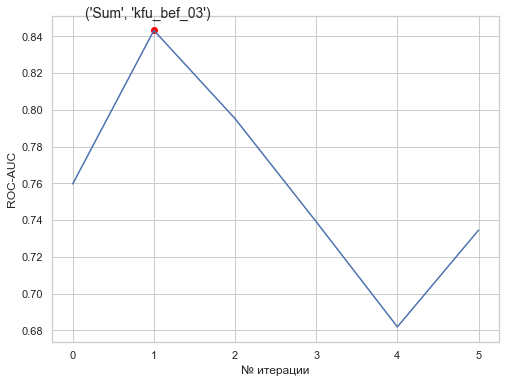

In [150]:
plt.figure(figsize=(8, 6))
plt.plot(best_scores)
plt.scatter(best_scores.index(max(best_scores)), max(best_scores), color='red')
plt.text(0.15, 0.85, f'{columns_combinations[best_scores.index(max(best_scores))]}', fontsize=14)
plt.xlabel('№ итерации')
plt.ylabel('ROC-AUC')
plt.plot();

Попробуем обучить модель на первых семи признаков, которые показали себя самыми значимыми для модели.

In [154]:
np.random.seed(SEED)

x_train_pair =  x_train_new4.loc[:, columns_combinations[best_scores.index(max(best_scores))]]
x_valid_pair =  x_valid_new4.loc[:, columns_combinations[best_scores.index(max(best_scores))]]

model_params2_new = best_params[best_scores.index(max(best_scores))]
model2_new = LGBMClassifier(objective="binary", **model_params2_new)

model2_new.fit(x_train_pair, y_train_new)
get_scores(y_valid_new, model2_new.predict(x_valid_pair), metrics=metrics)

accuracy_score: 0.8095238095238095
roc_auc_score: 0.8215102974828374


Наилучшая модель была получена для первой пары признаков: ('Sum', 'kfu_bef_03').  
ROC-AUC на тесте составил - 0.8215, доля верных ответов - 80.95238%.  
**Целевая метрика и доля верных ответов выросли.**

Посмотрим на веса важности этих признаков.

In [156]:
np.random.seed(SEED)

perm2_new = PermutationImportance(model2_new, random_state=SEED).fit(x_valid_pair, y_valid_new)
eli5.show_weights(perm2_new, feature_names=list(x_valid_pair))

Weight,Feature
0.2857 ± 0.1313,Sum
0.1571 ± 0.0883,kfu_bef_03


И наконец глянем на влияние каждого признака на предсказания факта ПДЗ.

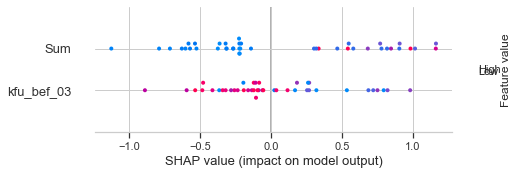

In [157]:
np.random.seed(SEED)

explainer2_new = shap.TreeExplainer(model2_new)
shap_values2_new = explainer2_new.shap_values(x_valid_pair)
shap.summary_plot(shap_values2_new[1], x_valid_pair)

Описание графика такое же, как было описано выше. Нового здесь добавить нечего.

**Вывод**:
- для предсказания факта ПДЗ для новых контрагентов лучше использовать комбинацию следующих признаков: "Sum" и "kfub_bef_03" (коэффициент финансовой устойчивости по данным -3 года, относительно текущего); эта комбинация позволяет получить точность предсказаний ~81%.

<h1>7 Заключение</h1>

В ходе проделанной работы по анализу контрагентов и выявлению факторов просрочки дебеторской задолженности были промоделированы две ситуации:
1) взаимодействие со старыми контрагентами, т.е. с таким, с которым было сотрудничество ранее;
2) взаимодействие с исключительно новыми контрагентоми.

Эти ситуации влияют на признаки, которые брались для обучения модели. Так для случая "взаимодействие со старым контрагентами" использовались признаки, содержащие
информацию о ПДЗ, чего не было для случая "взаимодействие с исключительно новыми контрагентоми".

В итоге была получена точность в 81% для первого и второго случаев. Метрика ROC-AUC равна 0.82609 и 0.82151 для первого и второго случая соответственно.

На предсказания модели в первом случае влияют следующие параметры:
- сумма факторных признаков (должна более релевантно отражать факторные характеристики контрагента, т.е. иметь меньше пропусков);
- kfu_bef_03 (коэффициент финансовой устойчивости, по данным -3 года относительно текущего) (сем меньше значение, тем более точнее получим предсказание);
- ar_sum_bef_01 (общая сумма ПДЗ свыше 5 дней, за прошлый год);
- ROA_ncl_bef_02 (рентабельность внеоборотных активов по данным -2 года, относительно текукщего);
- non_current_assets_diff_bef_03_04 (абсолютное изменение стоимости внеоборотных активов -3 года к -4);
- cost_amount_diff_bef_03_04(абсолютное изменение себестоимости -3 года к -4);
- accounts_payable_diff_frac_bef_03_04 (относительное изменение уровня кредиторской задолженности -3 года к -4);
- max_ar_bef_01 (максисмальный срок ПДЗ дней, за прошедший год). 
Признаки в большинстве своём положительно влияют на предсказания модели только благодаря взаимодействую с другими признаками.
Можно сказать, что в пространстве признаков, описывающем старых контрагентов, присутствует синергия между признаками, на которых была обучена модель.